In [2]:
import sys, os
sys.path.append("C:/Users/pjsin/Documents/cantera/build/python")
import cantera as ct
import matplotlib.pyplot as plt
import pandas as pd
import time
import scipy
import scipy.optimize
from scipy.optimize import curve_fit
import numpy as np
from matplotlib import gridspec

hfont = {'fontname':'sans-serif','fontweight':550,'fontsize':10,'fontstretch':500}

### 1)      CREATING THE CHEMICAL MECHANISM FILE AND DEFINING LMRR PARAMETERS FOR PRESSURE-DEPENDENT REACTIONS

#### 1.1) Reaction 10: O + O (+M) <=> O2 (+M)
* Changed the efficiency of ‘Ar’ to 1.0

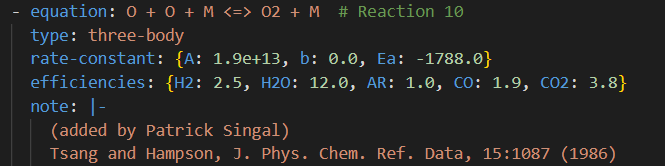

#### 1.2) Reaction 13: H + O2 (+M) <=> HO2 (+M)

##### **Step 1: PLOG fitting for Ar in reaction H + O2 (+Ar) <-> HO2 (+Ar)**

- {P: 1.316e-02, A: 1.13662e+35, b: -4.96606e-01, Ea: 3.35590e+01}
- {P: 1.316e-01, A: 1.20365e+35, b: -5.03779e-01, Ea: 5.65622e+01}
- {P: 3.947e-01, A: 1.19725e+35, b: -5.02971e-01, Ea: 7.25245e+01}
- {P: 1.000e+00, A: 1.17596e+35, b: -5.00284e-01, Ea: 9.27103e+01}
- {P: 3.000e+00, A: 1.13056e+35, b: -4.95365e-01, Ea: 1.21181e+02}
- {P: 1.000e+01, A: 1.09320e+35, b: -4.91679e-01, Ea: 1.68286e+02}
- {P: 3.000e+01, A: 9.72855e+34, b: -4.77838e-01, Ea: 2.11753e+02}
- {P: 1.000e+02, A: 8.66276e+34, b: -4.64944e-01, Ea: 2.89233e+02}


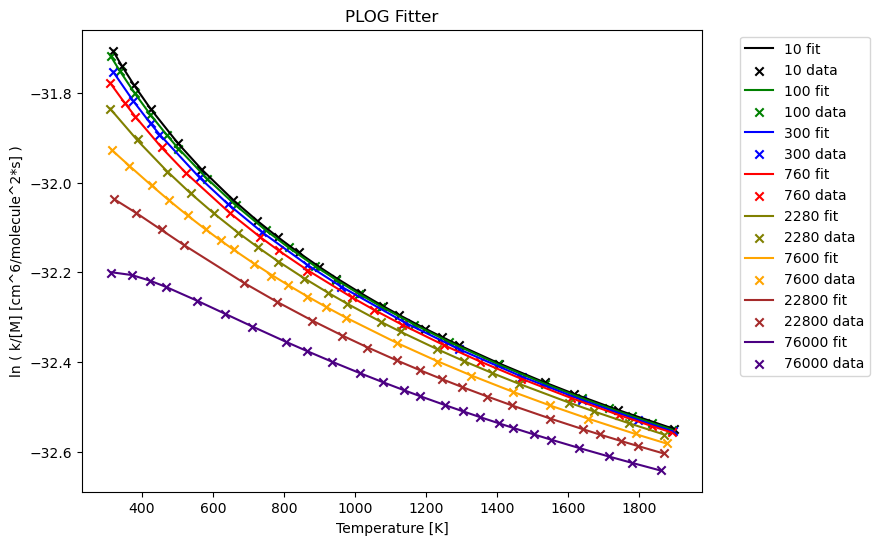

In [8]:
# def plog_fit():
#     path="G:\\Mon disque\\Columbia\\Burke Lab\\01 Mixture Rules Project\\"
#     fname="rateConstantCalculations_SKJFig5_truncated.csv"
#     p_list = [10,100,300,760,2280,7600,22800,76000]
#     for p in p_list:
#         def arrhenius_eq(T,A,n,Ea):
#             Rcal=1.987 #cal/molK
#             return np.log(A) + n*np.log(T)+ (-Ea/(Rcal*T))
#         dataset = pd.read_csv(path+fname)
#         dataset_p = dataset[dataset['P']==p]
#         T=dataset_p['T']
#         K=dataset_p['K']
#         params, covariance = curve_fit(arrhenius_eq,T,np.log(K),maxfev=100000)
#         print(("- {P: %.3e atm, A: %.5e, b: %.5e, Ea: %.5e}")%(p/760, params[0],params[1],params[2]))

# plog_fit() # init guesses for A, n, Ea

def arrhenius(T, A, n, Ea):
    return np.log(A) + n*np.log(T)+ (-Ea/(1.987*T))

# def calc_rc(T,A,n,Ea):
#     k = []
#     for temp in T:
#         k.append(A *(temp**n)* np.exp(-Ea/ (1.987* temp)))
#     return k

pltcolours = ['k','g','b','r','olive','orange','brown','indigo']
path="G:\\Mon disque\\Columbia\\Burke Lab\\01 Mixture Rules Project\\"
fname=path+"rateConstantCalculations_SKJFig5.csv"
reaction_plog = 'H + O2 <=> HO2'
reaction_troe = 'H + O2 (+M) <=> HO2 (+M)'

plt.figure(figsize=(8,6))
p_list = [10,100,300,760,2280,7600,22800,76000]
# p_list = [76000]
dataset = pd.read_csv(fname)
for i,p in enumerate(p_list):
    dataset_p = dataset[dataset['P(torr)']==p]
    p_data = dataset_p['P(atm)'] # atm
    T_data=dataset_p['T'] # K
    k_data_og=dataset_p['lnK/M (cm6/molec^2/sec)'] # ln(cm6/molec^2*s)
    # k_data=dataset_p['K (cm3/mol/sec)']  # cm3/mol/s
    
    N_A = 6.022e23 # molec/mol
    
    # R = 82.0573660809596 # cm3*atm/K*mol
    # C = np.divide(p_data,np.multiply(T_data,R))
    # k_converted = np.multiply( np.multiply(np.exp(k_data_og),np.square(N_A)) , C ) # cm3/mol/s
    
    k_converted = np.multiply(np.exp(k_data_og),np.square(N_A)) # cm6/mol2*s
    
    
    popt, pcov = curve_fit(arrhenius, T_data, np.log(k_converted),maxfev = 2000)
    print(("- {P: %.3e, A: %.5e, b: %.5e, Ea: %.5e}")%(p/760, popt[0],popt[1],popt[2]))
    lnk_fit = arrhenius(T_data,popt[0],popt[1],popt[2])

    plt.plot(T_data,np.log(np.divide(np.exp(lnk_fit),np.square(N_A))),label=str(p) + ' fit',linestyle='solid',color=pltcolours[i])
    plt.scatter(T_data,np.log(np.divide(k_converted,np.square(N_A))),marker='x',color=pltcolours[i],label=str(p) + ' data')
    
plt.title('PLOG Fitter')
plt.xlabel('Temperature [K]')
plt.ylabel('ln ( k/[M] [cm^6/molecule^2*s] )')
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.show()

##### **Step 2: Load the calculated parameters into sandbox.yaml**

##### **Step 3: Plot the PLOG fit and graph-read data for Ar in reaction H + O2 (+Ar) <-> HO2 (+Ar)**

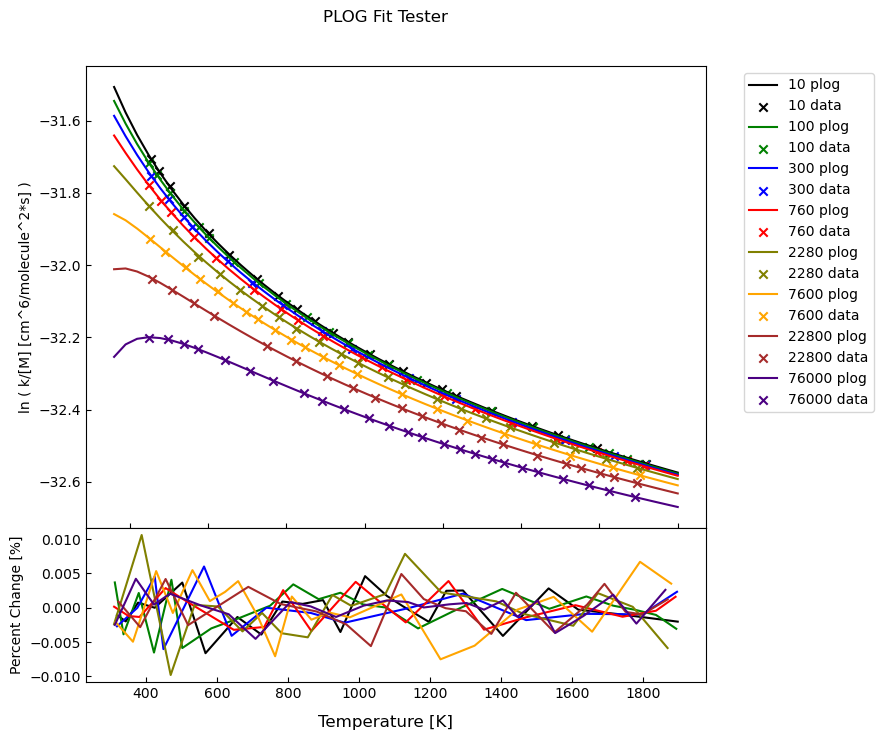

In [11]:
fig = plt.figure(figsize=(8, 8))
spec = gridspec.GridSpec(ncols=1, nrows=2,hspace=0, height_ratios=[3, 1])
fig.suptitle(t='PLOG Fit Tester', x=0.5, y=0.95)
fig.supxlabel(t='Temperature [K]', x=0.5, y=0.05)
ax0 = fig.add_subplot(spec[0])
ax1 = fig.add_subplot(spec[1])
ax0.set_ylabel('ln ( k/[M] [cm^6/molecule^2*s] )')
ax1.set_ylabel('Percent Change [%]')
p_list = [10,100,300,760,2280,7600,22800,76000]
T_list = np.linspace(200,2000,50)
for i, p in enumerate(p_list):
    ratelist_plog = []
    ratelist_troe = []
    for j, T in enumerate(T_list):
        gas = ct.Solution('test/data/sandbox.yaml')
        # print(p)
        gas.TPX = T, p/760, 'H2:0.2,O2:0.2,Ar:0.8'
        rc_plog = gas.forward_rate_constants[gas.reaction_equations().index(reaction_plog)] # m3/kmol/s
        rc_plog = rc_plog*1000 # cm3/mol*s
        rc_plog_M_molec = np.divide(rc_plog, np.square(N_A)) # cm6/molec2*s
        ratelist_plog.append(np.log(rc_plog_M_molec))
    ax0.plot(T_list,ratelist_plog,label=str(p) + ' plog',linestyle='solid',color=pltcolours[i])
    dataset = pd.read_csv(fname) # data from klippy
    dataset_p = dataset[dataset['P(torr)']==p]
    T_data=dataset_p['T']
    k_data_og=dataset_p['lnK/M (cm6/molec^2/sec)']  # cm3/mol/s
    ax0.scatter(T_data,k_data_og,marker='x',color=pltcolours[i],label=str(p) + ' data')
    ax1.plot(T_data, np.multiply(np.divide(np.subtract(np.interp(T_data,T_list,ratelist_plog),k_data_og),k_data_og),100),label=str(p) + ' plog',linestyle='solid',color=pltcolours[i])
ax0.tick_params(direction='in')
ax1.tick_params(direction='in')
ax0.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.show()

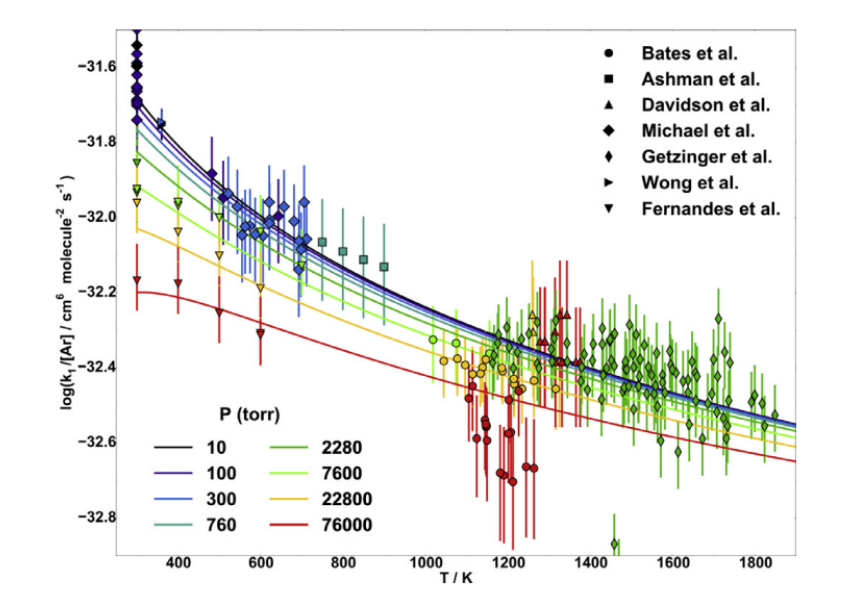

1. use lsq fit instead of curve fit, with 2 points not 3
2. do more sanity checks along the way
3. use Jasper for collision efficiencies in other reactions. There will be instances where glarborg model has efficiencies for things that jasper hasn't calculated. In that case, use the glarborg version as the efficiency (he will only have T-indep efficiencies, so put that as A factor and the other two params to zero )
4. add in additional rxns to alzueta (see email)

Keep a log of all the checks I have done along the way and their results.

Also look back on google doc instruction list (lots of error check suggestions in there)

To validate. Check assumption of same reduced-pressure dependence by defining in yaml as below. If at a given T (corresponding to the eff that you choose to divide the pressure by) the values at a certain P produce the same k between M and "H2O", then it means that the code's internal accounting system is working well

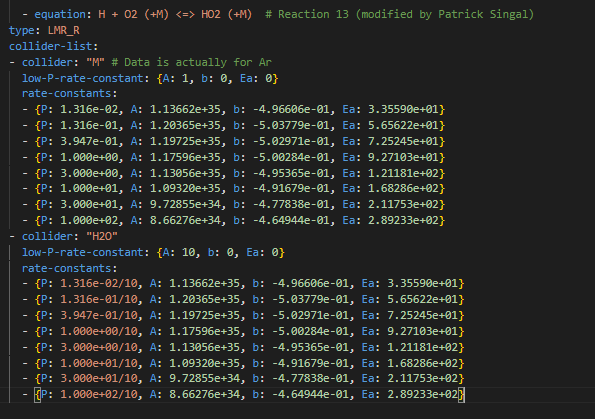



##### **Step 4: Use collision efficiencies to compute low-P limit rate constants for other colliders beyond Ar (i.e., H2O, NH3) in reaction H + O2 (+M) <-> HO2 (+M)**

In [58]:
# # FITTING ALL THREE PARAMETERS
# def plot_ratefit(temperatures, rate_constants,pltcolour,labell):
#     def arrhenius_rate(T, A, beta, Ea):
#         R = 8.314  # Gas constant in J/(mol K)
#         return A * T**beta * np.exp(-Ea / (R * T))

#     def fit_function(T, A, beta, Ea):
#         return np.log(arrhenius_rate(T, A, beta, Ea))

#     initial_guess = [1.0e6, 0.5, 50.0]  
#     params, covariance = curve_fit(fit_function, temperatures, np.log(rate_constants), p0=initial_guess,maxfev=100000)
#     A_fit, beta_fit, Ea_fit = params
#     T_range = np.linspace(200, 2000, 100)
#     fit_curve = np.exp(fit_function(T_range, A_fit, beta_fit, Ea_fit))
#     plt.plot(T_range, fit_curve, label=labell,color=pltcolour)
#     plt.scatter(temperatures, rate_constants, label=None, color=pltcolour)
#     print(('- collider: "%s"\n  low-P-rate-constant: {A: %.5e, b: %.5e, Ea: %.5e}')%(labell.upper(),A_fit, beta_fit, Ea_fit))

# pltcolours = ['k','g','b','r','olive','orange','brown','indigo']
# plt.figure()
# plot_ratefit(np.array([300, 1000, 2000]),np.array([0.90, 1.17, 1.34]),pltcolours[0],"He")
# plot_ratefit(np.array([300, 1000, 2000]),np.array([1.71,1.58,1.20]),pltcolours[1],"N2")
# plot_ratefit(np.array([300, 1000, 2000]),np.array([3.69,3.07,1.71]),pltcolours[2],"H2")
# plot_ratefit(np.array([300, 1000, 2000]),np.array([13.7,8.94,3.03]),pltcolours[3],"CO2")
# plot_ratefit(np.array([300, 1000, 2000]),np.array([20.4,17.9,18.7]),pltcolours[4],"NH3")
# plot_ratefit(np.array([300, 1000, 2000]),np.array([23.3,22.2,21.3]),pltcolours[5],"H2O") 
# plt.xlabel('Temperature (K)')
# plt.ylabel('Rate Constant')
# plt.legend()
# plt.title("Fitting all three")
# plt.show()
# #FITTING ONLY A, Ea AND SETTING BETA==0
# def plot_ratefit(temperatures, rate_constants,pltcolour,labell):
#     def arrhenius_rate(T, A, Ea):
#         beta=0
#         R = 8.314  # Gas constant in J/(mol K)
#         return A * T**beta * np.exp(-Ea / (R * T))

#     def fit_function(T, A, Ea):
#         return np.log(arrhenius_rate(T, A, Ea))

#     initial_guess = [1.0e6, 50.0]  
#     params, covariance = curve_fit(fit_function, temperatures, np.log(rate_constants), p0=initial_guess,maxfev=100000)
#     A_fit, Ea_fit = params
#     T_range = np.linspace(200, 2000, 100)
#     fit_curve = np.exp(fit_function(T_range, A_fit, Ea_fit))
#     plt.plot(T_range, fit_curve, label=labell,color=pltcolour)
#     plt.scatter(temperatures, rate_constants, label=None, color=pltcolour)
# pltcolours = ['k','g','b','r','olive','orange','brown','indigo']
# plt.figure()
# plot_ratefit(np.array([300, 1000, 2000]),np.array([0.90, 1.17, 1.34]),pltcolours[0],"He")
# plot_ratefit(np.array([300, 1000, 2000]),np.array([1.71,1.58,1.20]),pltcolours[1],"N2")
# plot_ratefit(np.array([300, 1000, 2000]),np.array([3.69,3.07,1.71]),pltcolours[2],"H2")
# plot_ratefit(np.array([300, 1000, 2000]),np.array([13.7,8.94,3.03]),pltcolours[3],"CO2")
# plot_ratefit(np.array([300, 1000, 2000]),np.array([20.4,17.9,18.7]),pltcolours[4],"NH3")
# plot_ratefit(np.array([300, 1000, 2000]),np.array([23.3,22.2,21.3]),pltcolours[5],"H2O") 
# plt.xlabel('Temperature (K)')
# plt.ylabel('Rate Constant')
# plt.legend()
# plt.title("Fitting A and Ea")
# plt.show()

# #FITTING ONLY A AND BETA
# def plot_ratefit(temperatures, rate_constants,pltcolour,labell):
#     def arrhenius_rate(T, A, beta):
#         R = 8.314  # Gas constant in J/(mol K)
#         Ea=0
#         return A * T**beta * np.exp(-Ea / (R * T))

#     def fit_function(T, A, beta):
#         return np.log(arrhenius_rate(T, A, beta))

#     initial_guess = [1.0e6, 0.5]  
#     params, covariance = curve_fit(fit_function, temperatures, np.log(rate_constants), p0=initial_guess,maxfev=100000)
#     A_fit, beta_fit = params
#     T_range = np.linspace(200, 2000, 100)
#     fit_curve = np.exp(fit_function(T_range, A_fit, beta_fit))
#     plt.plot(T_range, fit_curve, label=labell,color=pltcolour)
#     plt.scatter(temperatures, rate_constants, label=None, color=pltcolour)

# pltcolours = ['k','g','b','r','olive','orange','brown','indigo']
# plt.figure()
# plot_ratefit(np.array([300, 1000, 2000]),np.array([0.90, 1.17, 1.34]),pltcolours[0],"He")
# plot_ratefit(np.array([300, 1000, 2000]),np.array([1.71,1.58,1.20]),pltcolours[1],"N2")
# plot_ratefit(np.array([300, 1000, 2000]),np.array([3.69,3.07,1.71]),pltcolours[2],"H2")
# plot_ratefit(np.array([300, 1000, 2000]),np.array([13.7,8.94,3.03]),pltcolours[3],"CO2")
# plot_ratefit(np.array([300, 1000, 2000]),np.array([20.4,17.9,18.7]),pltcolours[4],"NH3")
# plot_ratefit(np.array([300, 1000, 2000]),np.array([23.3,22.2,21.3]),pltcolours[5],"H2O") 
# plt.xlabel('Temperature (K)')
# plt.ylabel('Rate Constant')
# plt.legend()
# plt.title("Fitting A and Beta")
# plt.show()

# #FITTING Beta and Ea
# def plot_ratefit(temperatures, rate_constants,pltcolour,labell):
#     def arrhenius_rate(T, beta, Ea):
#         R = 8.314  # Gas constant in J/(mol K)
#         A=1
#         return A * T**beta * np.exp(-Ea / (R * T))

#     def fit_function(T, beta, Ea):
#         return np.log(arrhenius_rate(T, beta, Ea))

#     initial_guess = [0.5, 50.0]  
#     params, covariance = curve_fit(fit_function, temperatures, np.log(rate_constants), p0=initial_guess,maxfev=100000)
#     beta_fit, Ea_fit = params
#     T_range = np.linspace(200, 2000, 100)
#     fit_curve = np.exp(fit_function(T_range,beta_fit, Ea_fit))
#     plt.plot(T_range, fit_curve, label=labell,color=pltcolour)
#     plt.scatter(temperatures, rate_constants, label=None, color=pltcolour)

# pltcolours = ['k','g','b','r','olive','orange','brown','indigo']
# plt.figure()
# plot_ratefit(np.array([300, 1000, 2000]),np.array([0.90, 1.17, 1.34]),pltcolours[0],"He")
# plot_ratefit(np.array([300, 1000, 2000]),np.array([1.71,1.58,1.20]),pltcolours[1],"N2")
# plot_ratefit(np.array([300, 1000, 2000]),np.array([3.69,3.07,1.71]),pltcolours[2],"H2")
# plot_ratefit(np.array([300, 1000, 2000]),np.array([13.7,8.94,3.03]),pltcolours[3],"CO2")
# plot_ratefit(np.array([300, 1000, 2000]),np.array([20.4,17.9,18.7]),pltcolours[4],"NH3")
# plot_ratefit(np.array([300, 1000, 2000]),np.array([23.3,22.2,21.3]),pltcolours[5],"H2O") 
# plt.xlabel('Temperature (K)')
# plt.ylabel('Rate Constant')
# plt.legend()
# plt.title("beta vs Ea")
# plt.show()

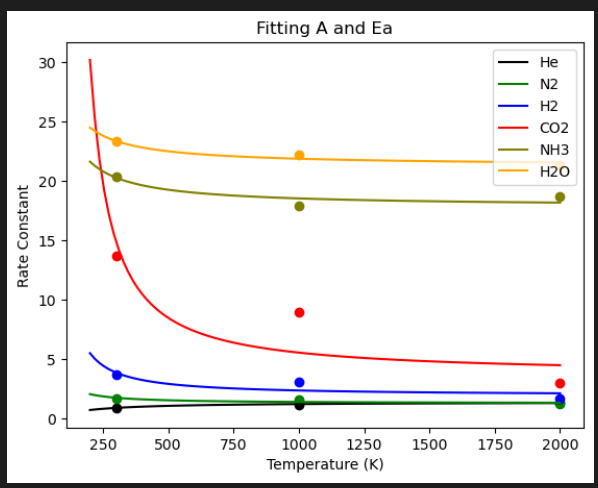
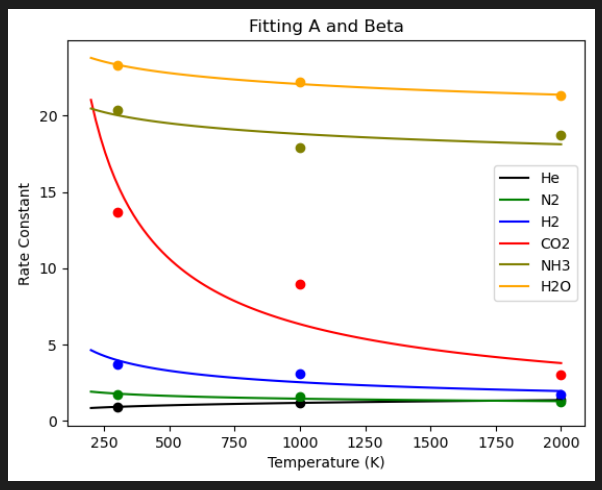
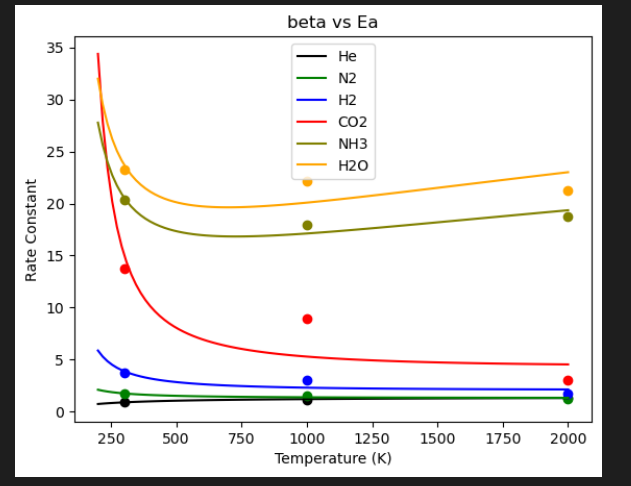
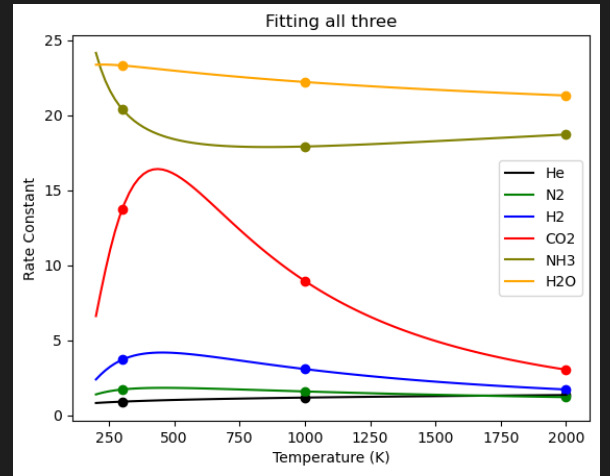

C:\Users\pjsin\AppData\Local\Temp\ipykernel_23688\3745376684.py:13: RuntimeWarning: invalid value encountered in log
  return np.log(arrhenius_rate(T, A, beta, Ea)) - ln_rate_constants


- collider: "HE"
  low-P-rate-constant: {A: 3.37601e-01, b: 1.82568e-01, Ea: 1.51639e+02}
- collider: "N2"
  low-P-rate-constant: {A: 1.24932e+02, b: -5.93263e-01, Ea: 2.26332e+03}
- collider: "H2"
  low-P-rate-constant: {A: 3.13717e+04, b: -1.25419e+00, Ea: 4.72497e+03}
- collider: "CO2"
  low-P-rate-constant: {A: 1.62413e+08, b: -2.27622e+00, Ea: 8.24384e+03}
- collider: "NH3"
  low-P-rate-constant: {A: 4.97750e+00, b: 1.64855e-01, Ea: -1.17304e+03}
- collider: "H2O"
  low-P-rate-constant: {A: 3.69146e+01, b: -7.12902e-02, Ea: 1.33512e+02}


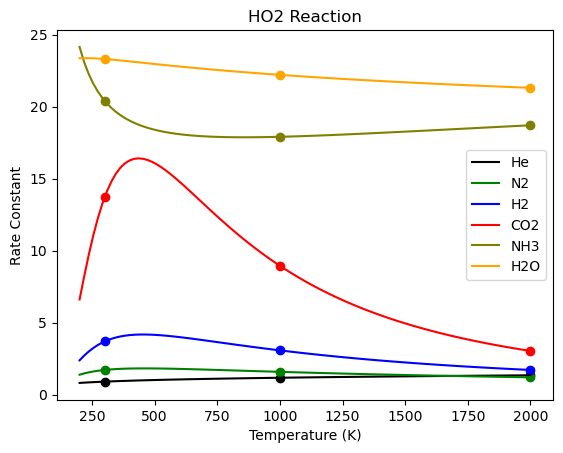

- collider: "N2"
  low-P-rate-constant: {A: 4.49281e+00, b: -9.46265e-02, Ea: -4.60560e+02}
- collider: "O2"
  low-P-rate-constant: {A: 1.15210e-01, b: 3.41234e-01, Ea: -1.62853e+03}
- collider: "CO2"
  low-P-rate-constant: {A: 9.19583e+00, b: 6.10696e-02, Ea: 3.77033e+02}
- collider: "NH3"
  low-P-rate-constant: {A: 1.49004e+01, b: 6.06535e-02, Ea: 1.03623e+03}
- collider: "CH4"
  low-P-rate-constant: {A: 1.26838e+01, b: 2.32014e-02, Ea: 9.38044e+02}
- collider: "H2O"
  low-P-rate-constant: {A: 1.14560e+01, b: 1.27501e-01, Ea: 1.31367e+03}


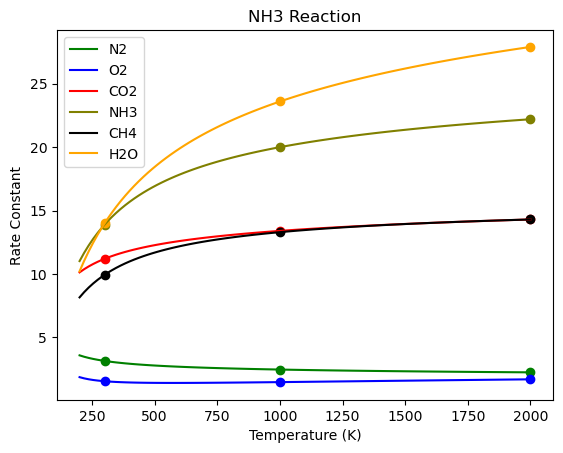

- collider: "N2"
  low-P-rate-constant: {A: 7.56771e+00, b: -1.96878e-01, Ea: 1.05930e+03}
- collider: "H2O"
  low-P-rate-constant: {A: 3.35451e+00, b: 1.33352e-01, Ea: 2.78096e+02}


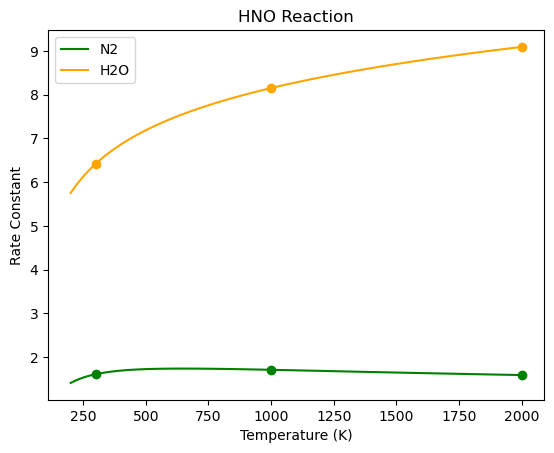

- collider: "N2"
  low-P-rate-constant: {A: 1.46848e+01, b: -3.00962e-01, Ea: 6.91004e+02}
- collider: "O2"
  low-P-rate-constant: {A: 1.53608e+00, b: -3.90857e-02, Ea: 1.85675e+01}
- collider: "NH3"
  low-P-rate-constant: {A: 1.64196e+01, b: -7.29636e-02, Ea: 1.53183e+03}
- collider: "H2O"
  low-P-rate-constant: {A: 2.17658e+01, b: -1.14715e-01, Ea: 1.75408e+03}


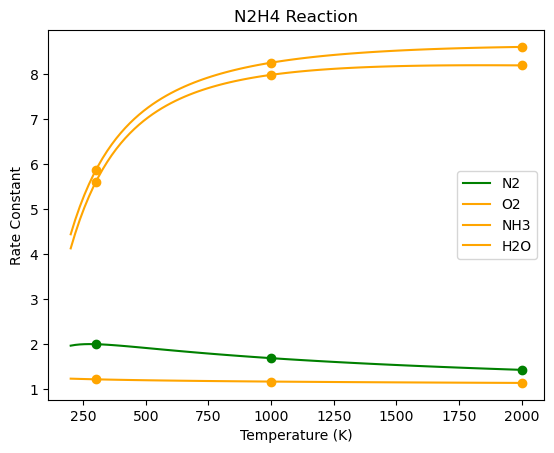

- collider: "AR"
  low-P-rate-constant: {A: 2.20621e-02, b: 4.74036e-01, Ea: -4.73434e+02}
- collider: "H2O"
  low-P-rate-constant: {A: 1.04529e-01, b: 5.50787e-01, Ea: -9.73558e+02}


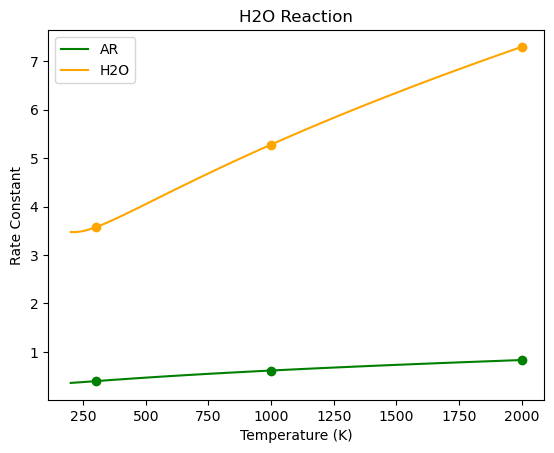

- collider: "N2"
  low-P-rate-constant: {A: 1.14813e+00, b: 4.60090e-02, Ea: -1.22351e+01}
- collider: "CO2"
  low-P-rate-constant: {A: 8.98839e+01, b: -4.27974e-01, Ea: 1.01003e+03}
- collider: "H2O2"
  low-P-rate-constant: {A: 6.45295e-01, b: 4.26266e-01, Ea: 1.79473e+02}
- collider: "H2O"
  low-P-rate-constant: {A: 1.36377e+00, b: 3.06592e-01, Ea: 8.79010e+02}


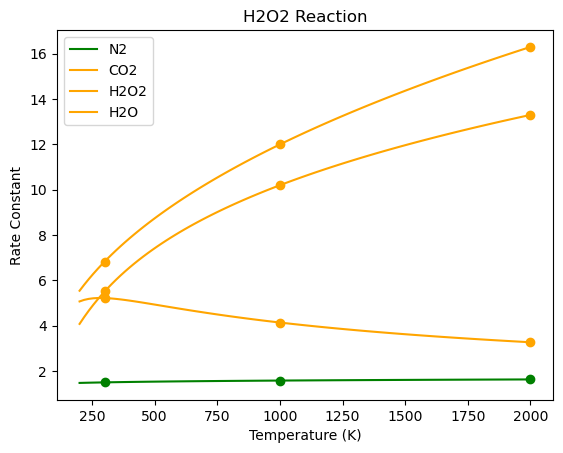

In [116]:
#LEAST-SQUARES FITTING OF COLLISION EFFICIENCIES

import numpy as np
from scipy.optimize import least_squares
import matplotlib.pyplot as plt

def arrhenius_rate(T, A, beta, Ea):
    R = 8.314  # Gas constant in J/(mol K)
    return A * T**beta * np.exp(-Ea / (R * T))

def fit_function(params, T, ln_rate_constants):
    A, beta, Ea = params
    return np.log(arrhenius_rate(T, A, beta, Ea)) - ln_rate_constants

def plot_ratefit(temperatures, rate_constants, pltcolour, labell):
    initial_guess = [1.0e6, 0.5, 50.0]  
    result = least_squares(fit_function, initial_guess, args=(temperatures, np.log(rate_constants)))

    A_fit, beta_fit, Ea_fit = result.x

    T_range = np.linspace(200, 2000, 100)
    fit_curve = np.exp(np.log(arrhenius_rate(T_range, A_fit, beta_fit, Ea_fit)))
    print(('- collider: "%s"\n  low-P-rate-constant: {A: %.5e, b: %.5e, Ea: %.5e}')%(labell.upper(),A_fit, beta_fit, Ea_fit))
    plt.plot(T_range, fit_curve, label=labell, color=pltcolour)
    plt.scatter(temperatures, rate_constants, label=None, color=pltcolour)

pltcolours = ['k', 'g', 'b', 'r', 'olive', 'orange', 'brown', 'indigo']

#FOR HO2 REACTION
plt.figure()
plot_ratefit(np.array([300, 1000, 2000]), np.array([0.90, 1.17, 1.34]), pltcolours[0], "He")
plot_ratefit(np.array([300, 1000, 2000]), np.array([1.71, 1.58, 1.20]), pltcolours[1], "N2")
plot_ratefit(np.array([300, 1000, 2000]), np.array([3.69, 3.07, 1.71]), pltcolours[2], "H2")
plot_ratefit(np.array([300, 1000, 2000]), np.array([13.7, 8.94, 3.03]), pltcolours[3], "CO2")
plot_ratefit(np.array([300, 1000, 2000]), np.array([20.4, 17.9, 18.7]), pltcolours[4], "NH3")
plot_ratefit(np.array([300, 1000, 2000]), np.array([23.3, 22.2, 21.3]), pltcolours[5], "H2O") 
plt.xlabel('Temperature (K)')
plt.ylabel('Rate Constant')
plt.legend()
plt.title("HO2 Reaction")
plt.show()

#FOR NH3 REACTION
plt.figure()
plot_ratefit(np.array([300, 1000, 2000]), np.array([3.15,2.47,2.25]), pltcolours[1], "N2")
plot_ratefit(np.array([300, 1000, 2000]), np.array([1.55,1.48,1.70]), pltcolours[2], "O2")
plot_ratefit(np.array([300, 1000, 2000]), np.array([11.2,13.4,14.3]), pltcolours[3], "CO2")
plot_ratefit(np.array([300, 1000, 2000]), np.array([13.9,20.0,22.2]), pltcolours[4], "NH3")
plot_ratefit(np.array([300, 1000, 2000]), np.array([9.94,13.3,14.3]), pltcolours[0], "CH4")
plot_ratefit(np.array([300, 1000, 2000]), np.array([14.0,23.6,27.9]), pltcolours[5], "H2O") 
plt.xlabel('Temperature (K)')
plt.ylabel('Rate Constant')
plt.legend()
plt.title("NH3 Reaction")
plt.show()

#FOR HNO REACTION
plt.figure()
plot_ratefit(np.array([300, 1000, 2000]), np.array([1.61,1.71,1.59]), pltcolours[1], "N2")
plot_ratefit(np.array([300, 1000, 2000]), np.array([6.42,8.15,9.09]), pltcolours[5], "H2O") 
plt.xlabel('Temperature (K)')
plt.ylabel('Rate Constant')
plt.legend()
plt.title("HNO Reaction")
plt.show()

#FOR N2H4 REACTION
plt.figure()
plot_ratefit(np.array([300,1000,2000]), np.array([2.00,1.69,1.43]), pltcolours[1], "N2")
plot_ratefit(np.array([300,1000,2000]), np.array([1.22,1.17,1.14]), pltcolours[5], "O2") 
plot_ratefit(np.array([300,1000,2000]), np.array([5.86,8.25,8.60]), pltcolours[5], "NH3") 
plot_ratefit(np.array([300,1000,2000]), np.array([5.60,7.98,8.19]), pltcolours[5], "H2O") 
plt.xlabel('Temperature (K)')
plt.ylabel('Rate Constant')
plt.legend()
plt.title("N2H4 Reaction")
plt.show()

#FOR H2O REACTION
plt.figure()
plot_ratefit(np.array([300,1000,2000]), np.array([1/2.51,1/1.62,1/1.20]), pltcolours[1], "AR")
plot_ratefit(np.array([300,1000,2000]), np.array([8.97/2.51,8.55/1.62,8.75/1.20]), pltcolours[5], "H2O") 
plt.xlabel('Temperature (K)')
plt.ylabel('Rate Constant')
plt.legend()
plt.title("H2O Reaction")
plt.show()

#FOR H2O2 REACTION
plt.figure()
plot_ratefit(np.array([300,1000,2000]), np.array([1.50,1.58,1.63]), pltcolours[1], "N2")
plot_ratefit(np.array([300,1000,2000]), np.array([5.22,4.14,3.27]), pltcolours[5], "CO2")
plot_ratefit(np.array([300,1000,2000]), np.array([6.83,12.0,16.3]), pltcolours[5], "H2O2") 
plot_ratefit(np.array([300,1000,2000]), np.array([5.51,10.2,13.3]), pltcolours[5], "H2O") 
plt.xlabel('Temperature (K)')
plt.ylabel('Rate Constant')
plt.legend()
plt.title("H2O2 Reaction")
plt.show()

#### 1.3) Reaction 69: NH3 <=> NH2 + H
* Was originally written in [alzuetamechanism_LMRR.yaml](https://drive.google.com/file/d/1ln--QaK9phmL9GVVyFz2-jMWSjjMKJ0b/view?usp=sharing) as "NH2 + H (+M) <=> NH3 (+M)", but I reversed the order to allow the tabular data (shown below) to be used
* Copied parameters from Table 1 of ["An experimental, theoretical and kinetic-modeling study of the gas-phase oxidation of ammonia"](https://drive.google.com/file/d/15JVwsEIgb1P6gJmXaWZOH6yQ5QkdQvjg/view?usp=sharing)
* Used the "temperature independent value" of the rate constant for ammonia decomposition (mentioned in the paper) as eig0

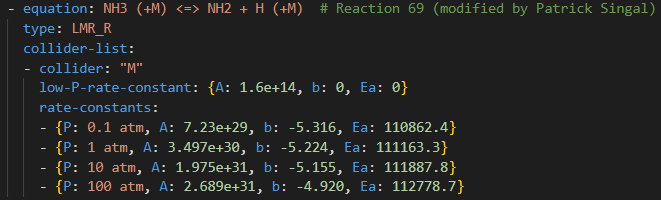 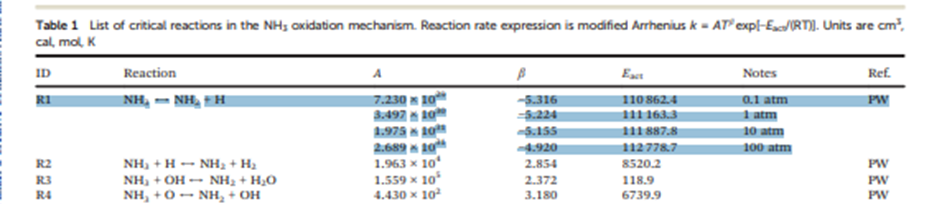

#### 1.4) Reaction 164: HNO (+M) <=> NO + H (+M)
* Was originally written in [alzuetamechanism_LMRR.yaml](https://drive.google.com/file/d/1ln--QaK9phmL9GVVyFz2-jMWSjjMKJ0b/view?usp=sharing) as "NO + H (+M) <=> HNO (+M)", but I reversed the order to allow the tabular data (shown below) to be used
* Copied parameters from Table 1 of ["An experimental, theoretical and kinetic-modeling study of the gas-phase oxidation of ammonia"](https://drive.google.com/file/d/15JVwsEIgb1P6gJmXaWZOH6yQ5QkdQvjg/view?usp=sharing)
* The eig0 value is still UNKNOWN

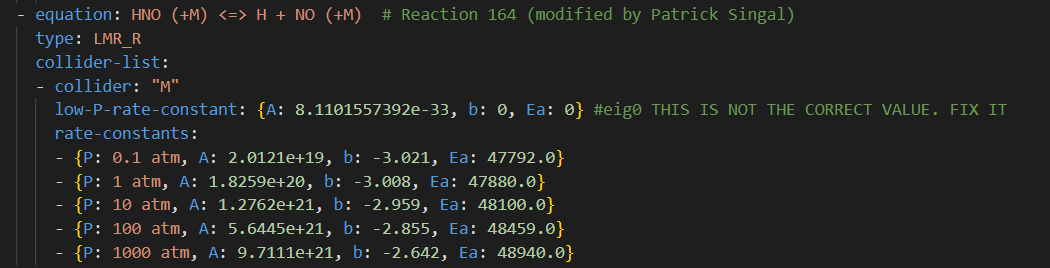
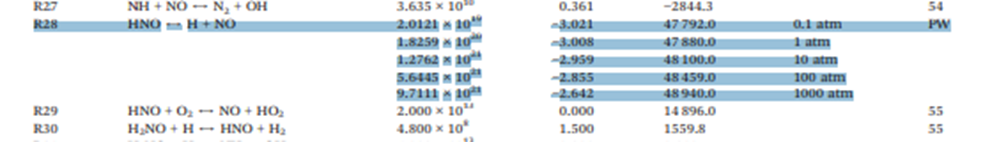

#### **1.5) NH2 + NH2 (+M) <=> N2H4 (+M) Reaction**

Original Troe table, using data from Klippenstein:
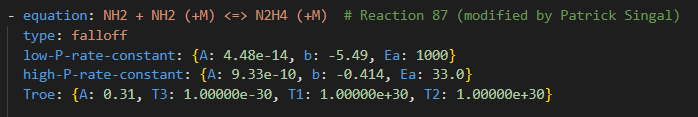

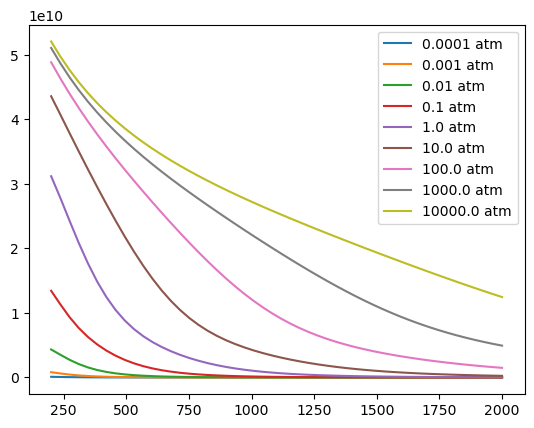

[[105638776.81936283, 78241227.86585718, 55196376.44944686, 38278547.18011426, 26499356.60700209, 18454259.825812455, 12977983.005615393, 9233045.639292644, 6649704.921838126, 4848458.037022382, 3577881.627664716, 2670967.269678425, 2016010.3565404757, 1537607.1458834012, 1184329.1793310216, 920718.2470061888, 722058.4423184766, 570934.7207623183, 454946.4888280091, 365173.4925588269, 295135.991369712, 240082.77162633624, 196498.734211358, 161760.99570748652, 133896.42282278213, 111409.10949371077, 93156.5333099197, 78259.89913708888, 66038.702338414, 55962.5948901331, 47615.71334313002, 40670.052085536736, 34865.45128832447, 29994.45691385753, 25890.794088669216, 22420.53813932076, 19475.312508238374, 16967.018903465505, 14823.732583321704, 12986.488653498196, 11406.753465405083, 10044.4255569705, 8866.247968299016, 7844.541690898907, 6956.190982376071, 6181.827114263904, 5505.169139356446, 4912.489432259134, 4392.178783122102, 3934.3912349233497], [821997015.5540591, 623942428.345632

In [97]:
#GET RATE CONSTANTS FROM TROE PARAMETERS (TAKEN FROM KLIPPENSTEIN Thermal Decomposition of NH2OH and Subsequent Reactions)
def getK(Temp,Pres,X) :
    file = 'test/data/sandbox.yaml'
    reaction = '2 NH2 (+M) <=> N2H4 (+M)'
    gas = ct.Solution(file)
    gas.TPX = Temp,Pres,X
    k = gas.forward_rate_constants[gas.reaction_equations().index(reaction)]
    return k

P_list=[0.0001*101325,0.001*101325,0.01*101325,0.1*101325,1*101325,10*101325,100*101325,1000*101325,10000*101325]
T_list=np.linspace(200,2000,50)
plt.figure()
k_P=[]
for P in P_list:
    k_T = []
    for T in T_list:
        k_T.append(getK(T,P,{'AR':1}))
    k_P.append(k_T)
    plt.plot(T_list,k_T,label=str(P/101325)+" atm")
plt.legend()
plt.show()
print(k_P)



- {P: 1.000e-04, A: 1.20024e+25, b: -6.43982e+00, Ea: 2.05356e+03}
- {P: 1.000e-03, A: 1.19856e+26, b: -6.43893e+00, Ea: 2.16055e+03}
- {P: 1.000e-02, A: 1.80223e+27, b: -6.48573e+00, Ea: 2.49649e+03}
- {P: 1.000e-01, A: 1.07660e+28, b: -6.40257e+00, Ea: 3.01349e+03}
- {P: 1.000e+00, A: 3.65176e+26, b: -5.65302e+00, Ea: 2.95891e+03}
- {P: 1.000e+01, A: 4.51325e+23, b: -4.50139e+00, Ea: 2.58051e+03}
- {P: 1.000e+02, A: 2.56240e+20, b: -3.31075e+00, Ea: 2.07400e+03}
- {P: 1.000e+03, A: 8.99670e+16, b: -2.12230e+00, Ea: 1.37012e+03}
- {P: 1.000e+04, A: 5.28067e+13, b: -1.06166e+00, Ea: 5.64223e+02}


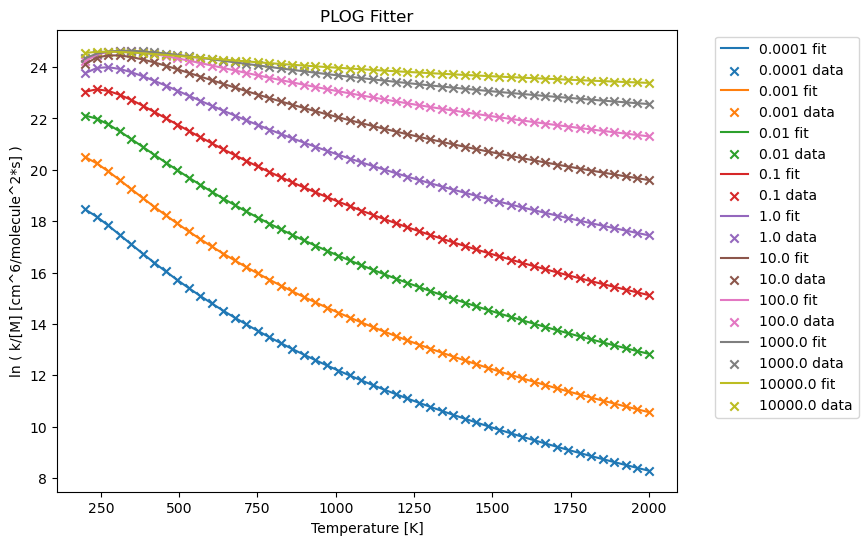

In [101]:
#Now do a PLOG fit with the above data

def arrhenius(T, A, n, Ea):
    return np.log(A) + n*np.log(T)+ (-Ea/(1.987*T))

# pltcolours = ['k','g','b','r','olive','orange','brown','indigo']
path="G:\\Mon disque\\Columbia\\Burke Lab\\01 Mixture Rules Project\\"
fname=path+"rateConstantCalculations_SKJFig5.csv"

plt.figure(figsize=(8,6))
dataset = pd.read_csv(fname)
for i,p in enumerate(P_list):
    # dataset_p = dataset[dataset['P(torr)']==p]
    # p_data = dataset_p['P(atm)'] # atm
    # T_data=dataset_p['T'] # K
    # k_data_og=dataset_p['lnK/M (cm6/molec^2/sec)'] # ln(cm6/molec^2*s)
    # # k_data=dataset_p['K (cm3/mol/sec)']  # cm3/mol/s
    
    # N_A = 6.022e23 # molec/mol
    
    # # R = 82.0573660809596 # cm3*atm/K*mol
    # # C = np.divide(p_data,np.multiply(T_data,R))
    # # k_converted = np.multiply( np.multiply(np.exp(k_data_og),np.square(N_A)) , C ) # cm3/mol/s
    
    # k_converted = np.multiply(np.exp(k_data_og),np.square(N_A)) # cm6/mol2*s
    
    k_data = k_P[i] #rate constants across a temperature range, for a given P
    
    popt, pcov = curve_fit(arrhenius, T_list, np.log(k_data),maxfev = 2000)
    print(("- {P: %.3e, A: %.5e, b: %.5e, Ea: %.5e}")%(p/101325, popt[0],popt[1],popt[2]))
    lnk_fit = arrhenius(T_list,popt[0],popt[1],popt[2])

    plt.plot(T_list,lnk_fit,label=str(p/101325) + ' fit',linestyle='solid')
    plt.scatter(T_list,lnk_fit,marker='x',label=str(p/101325) + ' data')
    
plt.title('PLOG Fitter')
plt.xlabel('Temperature [K]')
plt.ylabel('ln ( k/[M] [cm^6/molecule^2*s] )') #NEED TO VERIFY THE UNITS. ALMOST CERTAINLY INCORRECT
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.show()

#### **1.6) H2O + M <=> H + OH + M reaction**

original form (three-body)

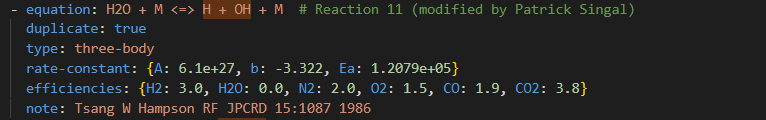

troe form

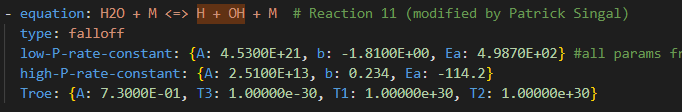

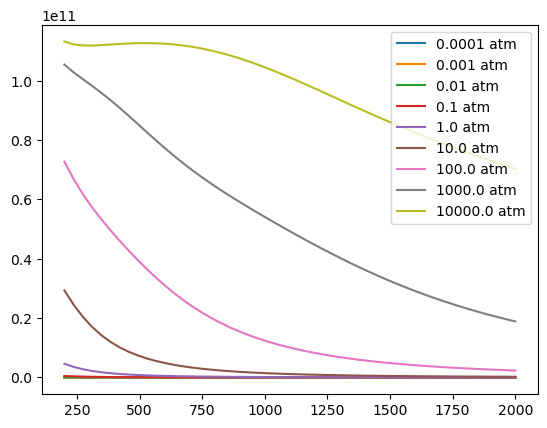

[[524319.5163683387, 396834.6319974504, 305232.2590543444, 238894.12434726002, 190108.76141424268, 153609.17700921983, 125834.55486895512, 104359.98391757939, 87511.21977571164, 74113.73548657217, 63330.05868584152, 54553.5508902942, 47338.16601286472, 41351.31766632872, 36341.769814818654, 32117.43218961942, 28529.781868537404, 25462.782476933833, 22824.899526623893, 20543.276061170367, 18559.435085896162, 16826.07421494755, 15304.6506592028, 13963.544324963097, 12776.64811182019, 11722.276938462202, 10782.316731561705, 9941.555629456028, 9187.154672744982, 8508.22609290025, 7895.495203466141, 7341.027697068123, 6838.008446531254, 6380.561114912194, 5963.600291041192, 5582.70969419164, 5234.0413849632205, 4914.231989174899, 4620.332767836876, 4349.751008290848, 4100.200713296263, 3869.660958996269, 3656.3406039835936, 3458.648278750824, 3275.166781841131, 3104.631166868321, 2945.909931597754, 2797.9888229283533, 2659.956854906118, 2530.994204748174], [5212331.094223178, 3946251.079387

In [107]:
#GET RATE CONSTANTS FROM TROE PARAMETERS (TAKEN FROM Solveig via Burke's email)
def getK(Temp,Pres,X) :
    file = 'test/data/sandbox.yaml'
    reaction = 'H + OH (+M) <=> H2O (+M)'
    gas = ct.Solution(file)
    gas.TPX = Temp,Pres,X
    k = gas.forward_rate_constants[gas.reaction_equations().index(reaction)]
    return k

P_list=[0.0001*101325,0.001*101325,0.01*101325,0.1*101325,1*101325,10*101325,100*101325,1000*101325,10000*101325]
T_list=np.linspace(200,2000,50)
plt.figure()
k_P=[]
for P in P_list:
    k_T = []
    for T in T_list:
        k_T.append(getK(T,P,{'N2':1}))
    k_P.append(k_T)
    plt.plot(T_list,k_T,label=str(P/101325)+" atm")
plt.legend()
plt.show()
print(k_P)



- {P: 1.000e-04, A: 5.30514e+12, b: -2.80725e+00, Ea: 4.99267e+02}
- {P: 1.000e-03, A: 5.25581e+13, b: -2.80630e+00, Ea: 4.99946e+02}
- {P: 1.000e-02, A: 5.18795e+14, b: -2.80495e+00, Ea: 5.01765e+02}
- {P: 1.000e-01, A: 5.13043e+15, b: -2.80388e+00, Ea: 5.08801e+02}
- {P: 1.000e+00, A: 5.47458e+16, b: -2.81214e+00, Ea: 5.50629e+02}
- {P: 1.000e+01, A: 1.04665e+18, b: -2.89077e+00, Ea: 8.27164e+02}
- {P: 1.000e+02, A: 6.24786e+18, b: -2.80241e+00, Ea: 1.43320e+03}
- {P: 1.000e+03, A: 4.28006e+15, b: -1.57172e+00, Ea: 9.80056e+02}
- {P: 1.000e+04, A: 6.79586e+12, b: -5.77830e-01, Ea: 4.56911e+02}


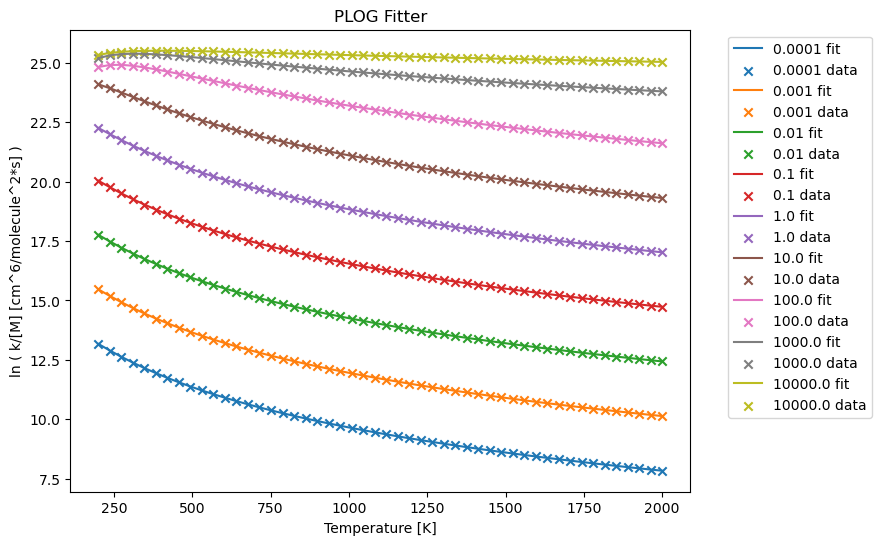

In [108]:
#Now do a PLOG fit with the above data

def arrhenius(T, A, n, Ea):
    return np.log(A) + n*np.log(T)+ (-Ea/(1.987*T))

# pltcolours = ['k','g','b','r','olive','orange','brown','indigo']
path="G:\\Mon disque\\Columbia\\Burke Lab\\01 Mixture Rules Project\\"
fname=path+"rateConstantCalculations_SKJFig5.csv"

plt.figure(figsize=(8,6))
dataset = pd.read_csv(fname)
for i,p in enumerate(P_list):
    # dataset_p = dataset[dataset['P(torr)']==p]
    # p_data = dataset_p['P(atm)'] # atm
    # T_data=dataset_p['T'] # K
    # k_data_og=dataset_p['lnK/M (cm6/molec^2/sec)'] # ln(cm6/molec^2*s)
    # # k_data=dataset_p['K (cm3/mol/sec)']  # cm3/mol/s
    
    # N_A = 6.022e23 # molec/mol
    
    # # R = 82.0573660809596 # cm3*atm/K*mol
    # # C = np.divide(p_data,np.multiply(T_data,R))
    # # k_converted = np.multiply( np.multiply(np.exp(k_data_og),np.square(N_A)) , C ) # cm3/mol/s
    
    # k_converted = np.multiply(np.exp(k_data_og),np.square(N_A)) # cm6/mol2*s
    
    k_data = k_P[i] #rate constants across a temperature range, for a given P
    
    popt, pcov = curve_fit(arrhenius, T_list, np.log(k_data),maxfev = 2000)
    print(("- {P: %.3e, A: %.5e, b: %.5e, Ea: %.5e}")%(p/101325, popt[0],popt[1],popt[2]))
    lnk_fit = arrhenius(T_list,popt[0],popt[1],popt[2])

    plt.plot(T_list,lnk_fit,label=str(p/101325) + ' fit',linestyle='solid')
    plt.scatter(T_list,lnk_fit,marker='x',label=str(p/101325) + ' data')
    
plt.title('PLOG Fitter')
plt.xlabel('Temperature [K]')
plt.ylabel('ln ( k/[M] [cm^6/molecule^2*s] )') #NEED TO VERIFY THE UNITS. ALMOST CERTAINLY INCORRECT
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.show()

#### 1.7) H2O2 (+M) <=> OH + OH (+M)

original troe form, provided by alzueta et al

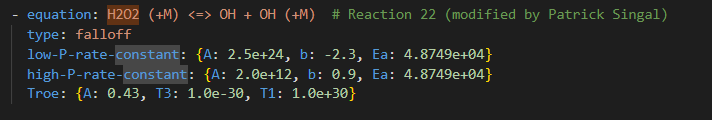

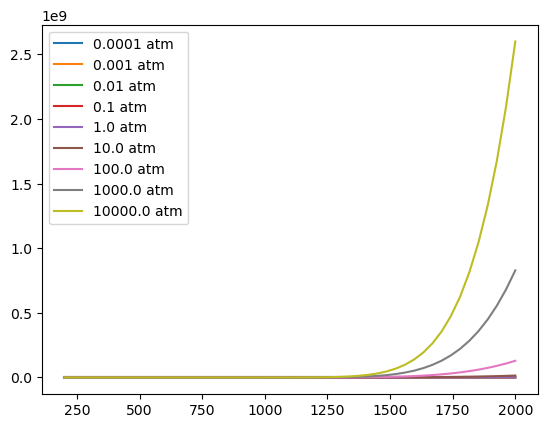

[[3.5776948897652e-43, 3.836540413262014e-35, 2.6719811257944246e-29, 7.294858682915708e-25, 2.1967301647328396e-21, 1.3799246610589468e-18, 2.7350312291876995e-16, 2.2637873400303998e-14, 9.524644162725869e-13, 2.3476239818817755e-11, 3.764987293743462e-10, 4.252993108342824e-09, 3.5968367462331205e-08, 2.388682627621631e-07, 1.293704157486974e-06, 5.89034812792026e-06, 2.3109385588432096e-05, 7.971961724794195e-05, 0.0002458937633296435, 0.0006877180573568631, 0.0017646771257941792, 0.00419607015966136, 0.009324725980760569, 0.019508040893674847, 0.03866417384793321, 0.07299470598548492, 0.13189445443162862, 0.22904537492525628, 0.3836760621073012, 0.6219529702658092, 0.9784557982719867, 1.497678895336261, 2.2354939947106502, 3.2605075117151987, 4.655248004242729, 6.5171257323753204, 8.959115816335403, 12.110128353371165, 16.11504203287673, 21.134391344439926, 27.34371057712986, 34.93254978851905, 44.1031882843005, 55.06907957737347, 68.0530681365004, 83.28542247734187, 101.001731393

In [114]:
#GET RATE CONSTANTS FROM TROE PARAMETERS (TAKEN FROM Solveig via Burke's email)
def getK(Temp,Pres,X) :
    file = 'test/data/sandbox.yaml'
    reaction = 'H2O2 (+M) <=> 2 OH (+M)'
    gas = ct.Solution(file)
    # print(gas.reaction_equations())
    gas.TPX = Temp,Pres,X
    k = gas.forward_rate_constants[gas.reaction_equations().index(reaction)]
    return k

P_list=[0.0001*101325,0.001*101325,0.01*101325,0.1*101325,1*101325,10*101325,100*101325,1000*101325,10000*101325]
T_list=np.linspace(200,2000,50)
plt.figure()
k_P=[]
for P in P_list:
    k_T = []
    for T in T_list:
        k_T.append(getK(T,P,{'AR':1}))
    k_P.append(k_T)
    plt.plot(T_list,k_T,label=str(P/101325)+" atm")
plt.legend()
plt.show()
print(k_P)


C:\Users\pjsin\AppData\Local\Temp\ipykernel_23688\798615052.py:4: RuntimeWarning: invalid value encountered in log
  return np.log(A) + n*np.log(T)+ (-Ea/(1.987*T))


- {P: 1.000e-04, A: 2.71622e+18, b: -3.29277e+00, Ea: 4.87751e+04}
- {P: 1.000e-03, A: 2.81583e+19, b: -3.29786e+00, Ea: 4.88063e+04}
- {P: 1.000e-02, A: 3.51720e+20, b: -3.32633e+00, Ea: 4.88987e+04}
- {P: 1.000e-01, A: 1.11349e+22, b: -3.47124e+00, Ea: 4.92510e+04}
- {P: 1.000e+00, A: 1.37798e+24, b: -3.78062e+00, Ea: 5.01239e+04}
- {P: 1.000e+01, A: 4.19865e+24, b: -3.60088e+00, Ea: 5.07633e+04}
- {P: 1.000e+02, A: 2.56115e+22, b: -2.63168e+00, Ea: 5.06995e+04}
- {P: 1.000e+03, A: 1.21632e+19, b: -1.40247e+00, Ea: 5.02104e+04}
- {P: 1.000e+04, A: 2.12510e+16, b: -4.29000e-01, Ea: 4.97239e+04}


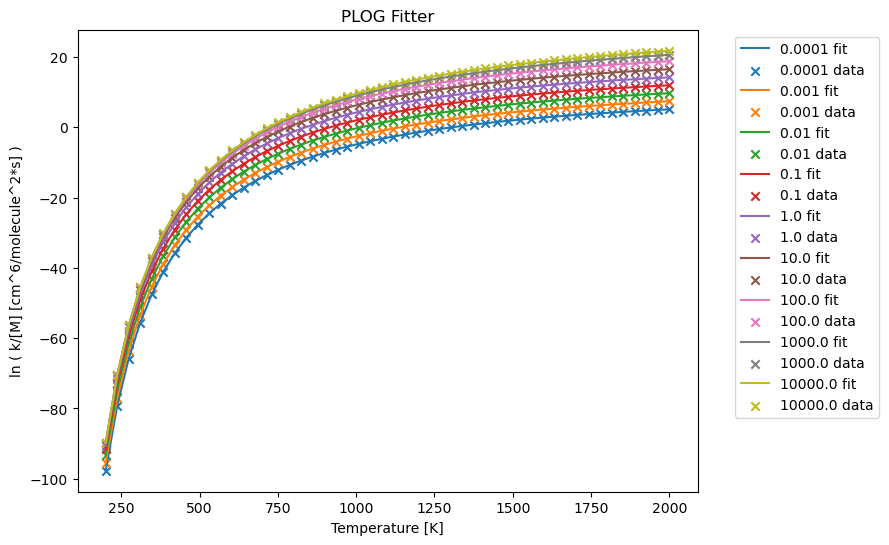

In [115]:
#Now do a PLOG fit with the above data

def arrhenius(T, A, n, Ea):
    return np.log(A) + n*np.log(T)+ (-Ea/(1.987*T))

# pltcolours = ['k','g','b','r','olive','orange','brown','indigo']
path="G:\\Mon disque\\Columbia\\Burke Lab\\01 Mixture Rules Project\\"
fname=path+"rateConstantCalculations_SKJFig5.csv"

plt.figure(figsize=(8,6))
dataset = pd.read_csv(fname)
for i,p in enumerate(P_list):
    # dataset_p = dataset[dataset['P(torr)']==p]
    # p_data = dataset_p['P(atm)'] # atm
    # T_data=dataset_p['T'] # K
    # k_data_og=dataset_p['lnK/M (cm6/molec^2/sec)'] # ln(cm6/molec^2*s)
    # # k_data=dataset_p['K (cm3/mol/sec)']  # cm3/mol/s
    
    # N_A = 6.022e23 # molec/mol
    
    # # R = 82.0573660809596 # cm3*atm/K*mol
    # # C = np.divide(p_data,np.multiply(T_data,R))
    # # k_converted = np.multiply( np.multiply(np.exp(k_data_og),np.square(N_A)) , C ) # cm3/mol/s
    
    # k_converted = np.multiply(np.exp(k_data_og),np.square(N_A)) # cm6/mol2*s
    
    k_data = k_P[i] #rate constants across a temperature range, for a given P
    
    popt, pcov = curve_fit(arrhenius, T_list, np.log(k_data),maxfev = 2000)
    print(("- {P: %.3e, A: %.5e, b: %.5e, Ea: %.5e}")%(p/101325, popt[0],popt[1],popt[2]))
    lnk_fit = arrhenius(T_list,popt[0],popt[1],popt[2])

    plt.plot(T_list,lnk_fit,label=str(p/101325) + ' fit',linestyle='solid')
    plt.scatter(T_list,lnk_fit,marker='x',label=str(p/101325) + ' data')
    
plt.title('PLOG Fitter')
plt.xlabel('Temperature [K]')
plt.ylabel('ln ( k/[M] [cm^6/molecule^2*s] )') #NEED TO VERIFY THE UNITS. ALMOST CERTAINLY INCORRECT
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.show()

### 2) SPECIES PROFILE: MOLE FRACTION VS TIME
* Figure 5: ["Shock tube/laser absorption measurement of the rate constant of the reaction: H2O2 + CO2 2OH + CO2" (Shao et al.)](https://drive.google.com/file/d/1sFTKvGt-wBRdPPPJMrivpzrz7SSJv9Ee/view?usp=sharing)

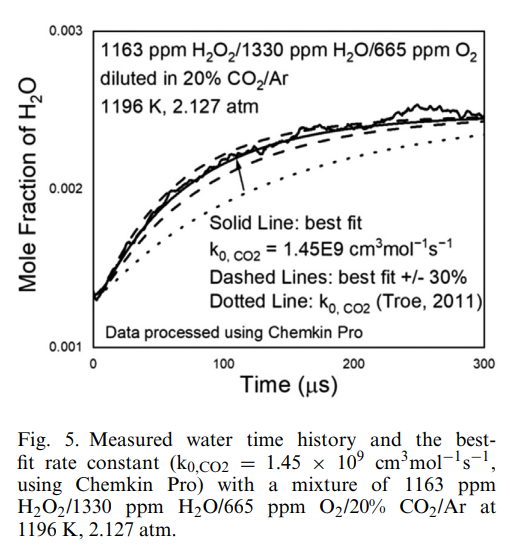

In [15]:
#REPRODUCING FIG 5
refSpecies='H2O'
X_H2O2 = 1163e-6
X_H2O = 1330e-6
X_O2 = 665e-6
X_CO2= 0.2*(1-X_H2O2-X_H2O-X_O2)
X_Ar = 1-X_CO2
def plotXvsTime(fname,pltlabel,pltcolour):
    # gas = ct.Solution('test/data/Burke_H2_ArBath.yaml')
    gas = ct.Solution(fname)
    gas.TPX = 1196, 2.127*101325, {'H2O2':X_H2O2, 'H2O':X_H2O, 'O2':X_O2, 'CO2':X_CO2, 'Ar':X_Ar}
    r = ct.Reactor(contents=gas,energy="on")
    reactorNetwork = ct.ReactorNet([r]) # this will be the only reactor in the network
    timeHistory = ct.SolutionArray(gas, extra=['t'])
    estIgnitDelay = 1
    t = 0
    counter = 1
    while t < estIgnitDelay:
        t = reactorNetwork.step()
        if counter % 20 == 0:
            timeHistory.append(r.thermo.state, t=t)
        counter += 1
    tConv = 1e6 #time conversion factor (1e6 converts to microseconds)
    timeShift=0 # [seconds]
    shiftedTime = tConv*(timeHistory.t - timeShift)
    moleFrac = timeHistory(refSpecies).X 
    plt.plot(shiftedTime, moleFrac, color=pltcolour,label=pltlabel)
plt.figure()
plotXvsTime("test/data/alzuetamechanism.yaml","w/out LMR","k")
plotXvsTime("test/data/alzuetamechanism_LMRR.yaml","w/ LMR","r")
plt.xlim([0,300])
# plt.xlim([100,150])
plt.ylim([0.001,0.003])
# plt.ylim([0.002,0.0022])
plt.ylabel("Mole Fraction of H2O",**hfont)
plt.xlabel("Time (μs)", **hfont)
plt.legend()


### 3) SPECIES PROFILE: CONCENTRATION VS TEMPERATURE
#### 3.1) H2/O2/Ar/H2O mixture 
* Figure 1: ["Mutual inhibition effect of hydrogen and ammonia in oxidation processes and the role of ammonia as “strong” collider in third-molecular reactions" (Sabia et al.)](https://drive.google.com/file/d/1lvcGuuSI6QafO6S_lkemsA5UyTIxl1Lr/view?usp=sharing)

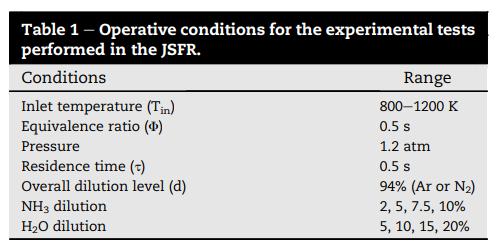
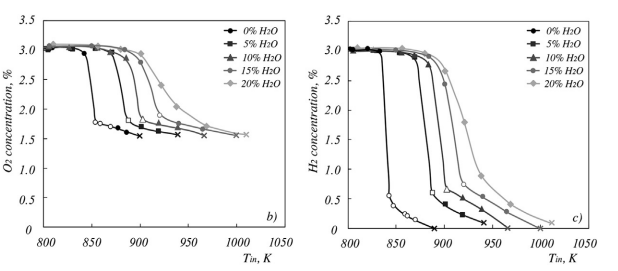

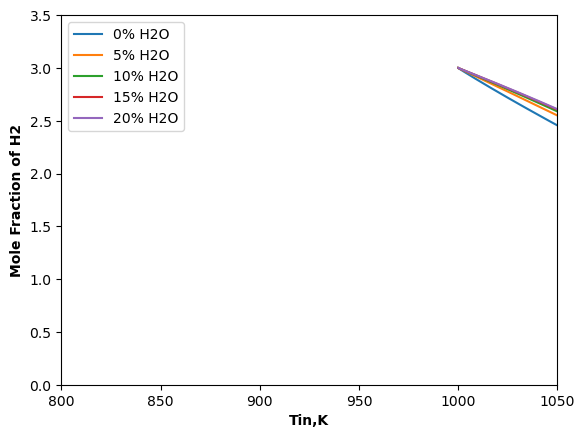

In [22]:
#REPRODUCING FIG 1
def plotXvsTemp(fname,pltlabel,pltcolour,fuel,oxidizer,diluent,refSpecies):
    gas = ct.Solution(fname)
    gas.TP = 1000, 1.2*101325
    gas.set_equivalence_ratio(0.5,fuel,oxidizer,diluent=diluent, fraction={"diluent":0.94},basis='mole')
    # Create a reactor
    reactor = ct.IdealGasReactor(gas)
    # Create a reactor network
    sim = ct.ReactorNet([reactor])
    # Time and data arrays for plotting
    times = []
    temperatures = []
    concentrations_H2 = []
    # Simulate the combustion reaction
    while sim.time < 50e-3:
        sim.step()
        times.append(sim.time)
        temperatures.append(reactor.T)
        concentrations_H2.append(gas[refSpecies].X[0]*100) #multiply by 100 to convert to a percentage
    plt.plot(temperatures,concentrations_H2,label=pltlabel)

plt.figure()
fname="test/data/alzuetamechanism.yaml"
plotXvsTemp(fname,"0% H2O","k",fuel='H2:1',oxidizer='O2:1',diluent='Ar:1.00,H2O:0.00',refSpecies='H2')
plotXvsTemp(fname,"5% H2O","k",fuel='H2:1',oxidizer='O2:1',diluent="Ar:0.95,H2O:0.05",refSpecies='H2')
plotXvsTemp(fname,"10% H2O","k",fuel='H2:1',oxidizer='O2:1',diluent="Ar:0.90,H2O:0.10",refSpecies='H2')
plotXvsTemp(fname,"15% H2O","k",fuel='H2:1',oxidizer='O2:1',diluent="Ar:0.85,H2O:0.15",refSpecies='H2')
plotXvsTemp(fname,"20% H2O","k",fuel='H2:1',oxidizer='O2:1',diluent="Ar:0.80,H2O:0.20",refSpecies='H2')
plt.xlim([800,1050])
plt.ylim([0,3.5])
plt.ylabel("Mole Fraction of H2",**hfont)
plt.xlabel("Tin,K", **hfont)
plt.legend()
plt.show()

#### 3.2) H2/O2/NH3/H2O mixture 
* Figure 2: ["Mutual inhibition effect of hydrogen and ammonia in oxidation processes and the role of ammonia as “strong” collider in third-molecular reactions" (Sabia et al.)](https://drive.google.com/file/d/1lvcGuuSI6QafO6S_lkemsA5UyTIxl1Lr/view?usp=sharing)

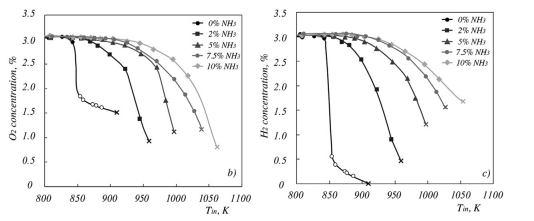

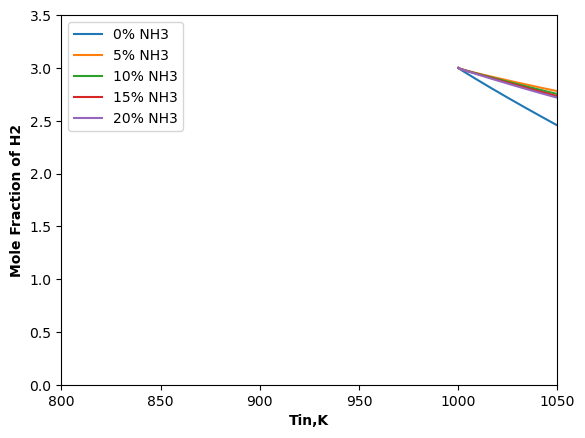

In [23]:
#REPRODUCING FIG 2
plt.figure()
fname="test/data/alzuetamechanism.yaml"
plotXvsTemp(fname,"0% NH3","k",fuel='H2:1',oxidizer='O2:1',diluent='Ar:1.00,NH3:0.00',refSpecies='H2')
plotXvsTemp(fname,"5% NH3","k",fuel='H2:1',oxidizer='O2:1',diluent="Ar:0.95,NH3:0.05",refSpecies='H2')
plotXvsTemp(fname,"10% NH3","k",fuel='H2:1',oxidizer='O2:1',diluent="Ar:0.90,NH3:0.10",refSpecies='H2')
plotXvsTemp(fname,"15% NH3","k",fuel='H2:1',oxidizer='O2:1',diluent="Ar:0.85,NH3:0.15",refSpecies='H2')
plotXvsTemp(fname,"20% NH3","k",fuel='H2:1',oxidizer='O2:1',diluent="Ar:0.80,NH3:0.20",refSpecies='H2')
plt.xlim([800,1050])
plt.ylim([0,3.5])
plt.ylabel("Mole Fraction of H2",**hfont)
plt.xlabel("Tin,K", **hfont)
plt.legend()
plt.show()

### 4) IGNITION DELAY TIME VS. TEMPERATURE
#### 4.1) H2/O2/N2 mixture 


* Figure 12: ["Ignition delay study of moist hydrogen/oxidizer mixtures using a rapid compression machine" (Das et al.)](https://drive.google.com/file/d/15wt6MQaSOY0MV6X_JQWMCGz20SSRR40R/view?usp=sharing)

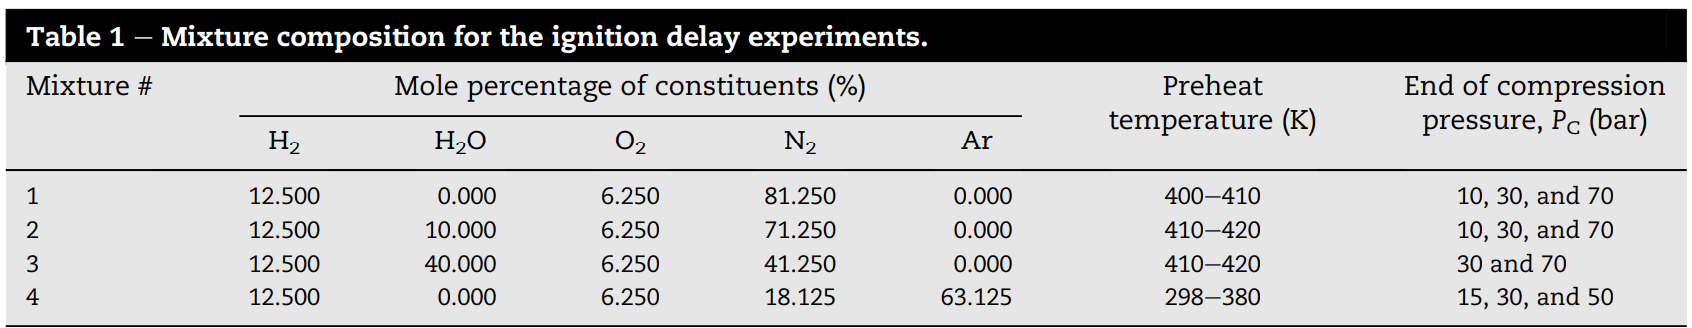

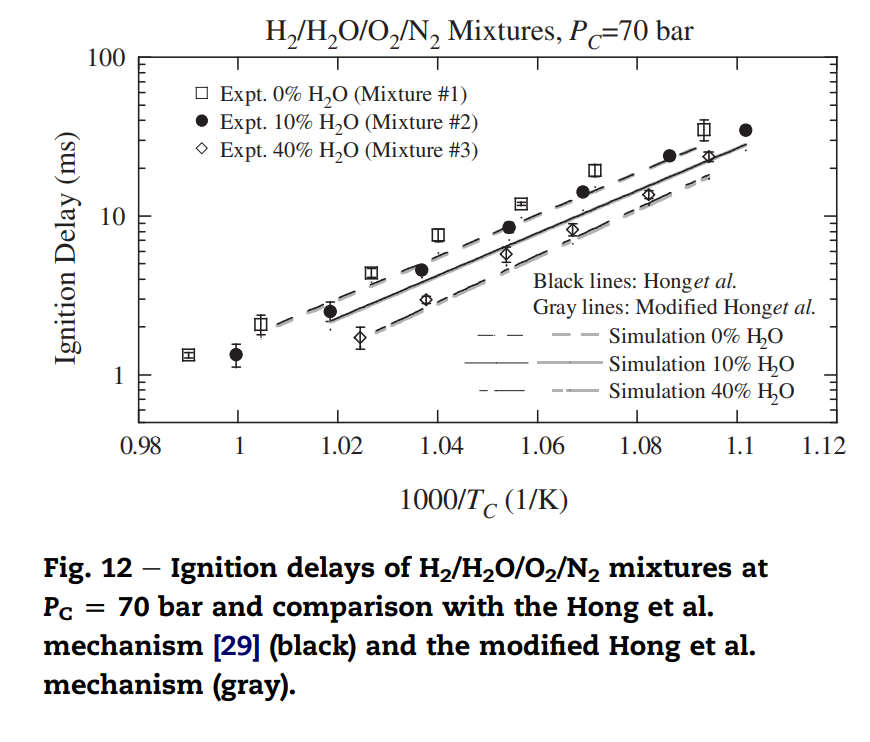

* Further reading: ["Estimation of third body efficiencies from experimental data: Application to hydrogen combustion" (Bertolino et al.)](https://drive.google.com/file/d/1b9eeWRiobquzTYwrdVpy5um8qbhHkl9T/view?usp=sharing)


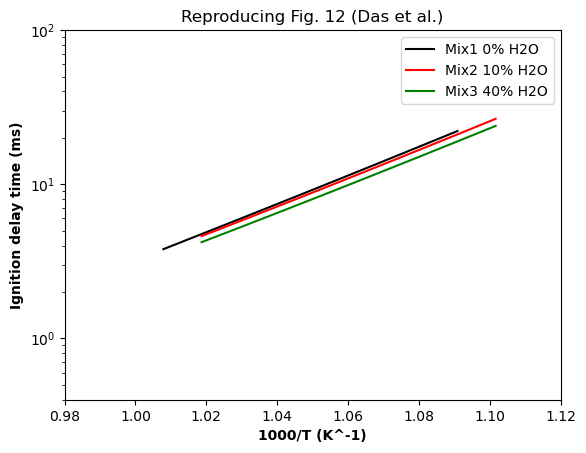

In [25]:
#REPRODUCING FIG 12
def plotIgnitionDelay_Fig12(fname,T,P,X,pltColour,pltLabel="_hidden",tConv=1e3): #tConv=1e3 converts from s to ms by default 
    refSpecies = "OH"
    estimated_ignition_delay_times = np.ones_like(T, dtype=float)
    gas = ct.Solution(fname)
    ignition_delays = ct.SolutionArray(gas, shape=T.shape, extra={"tau": estimated_ignition_delay_times})
    ignition_delays.TPX = T, P, X # [K], [Pa], [-]
    tau_list=[]
    for i, state in enumerate(ignition_delays):
        gas.TPX = state.TPX
        r = ct.Reactor(contents=gas, energy='on')
        reactor_network = ct.ReactorNet([r])
        refSpecies_history = []
        time_history = []
        t = 0
        while t < estimated_ignition_delay_times[i]:
            t = reactor_network.step()
            time_history.append(t)
            refSpecies_history.append(gas[refSpecies].X[0])
        i_ign = np.array(refSpecies_history).argmax()
        tau = time_history[i_ign]
        tau_list.append(tau) 
    plt.semilogy(1000 / ignition_delays.T, np.multiply(tConv,tau_list),'-',color=pltColour, marker=None,label=pltLabel)

plt.figure()
fname='test/data/alzuetamechanism.yaml'
P=70e5

T=np.divide(1000,np.arange(1.00789, 1.0915, 0.001))
X={'H2':0.125, 'O2':0.0625, 'H2O':0, 'N2':0.8125}
plotIgnitionDelay_Fig12(fname,T,P,X,'k',pltLabel='Mix1 0% H2O')

T=np.divide(1000,np.arange(1.018665, 1.10167, 0.001))
X={'H2':0.125, 'O2':0.0625, 'H2O':0.1, 'N2':0.7125}
plotIgnitionDelay_Fig12(fname,T,P,X,'r',pltLabel='Mix2 10% H2O')

T=np.divide(1000,np.arange(1.018665, 1.10167, 0.001))
X={'H2':0.125, 'O2':0.0625, 'H2O':0.4, 'N2':0.4125}
plotIgnitionDelay_Fig12(fname,T,P,X,'g',pltLabel='Mix3 40% H2O')

plt.title("Reproducing Fig. 12 (Das et al.)")
plt.ylabel("Ignition delay time (ms)",**hfont)
plt.xlabel(r"1000/T (K^-1)", **hfont)
plt.ylim([0.4,100])
plt.xlim([0.98,1.12])
plt.legend()
plt.show()

#### 4.2) NH3/O2/Ar mixture 
* Figure 9: ["A shock tube study of fuel concentration effect on high-pressure autoignition delay of ammonia" (Peng et al.)](https://drive.google.com/file/d/1JO1HS3WTDgLyB6KY0jVLoKAWNhu3Th0B/view?usp=sharing)

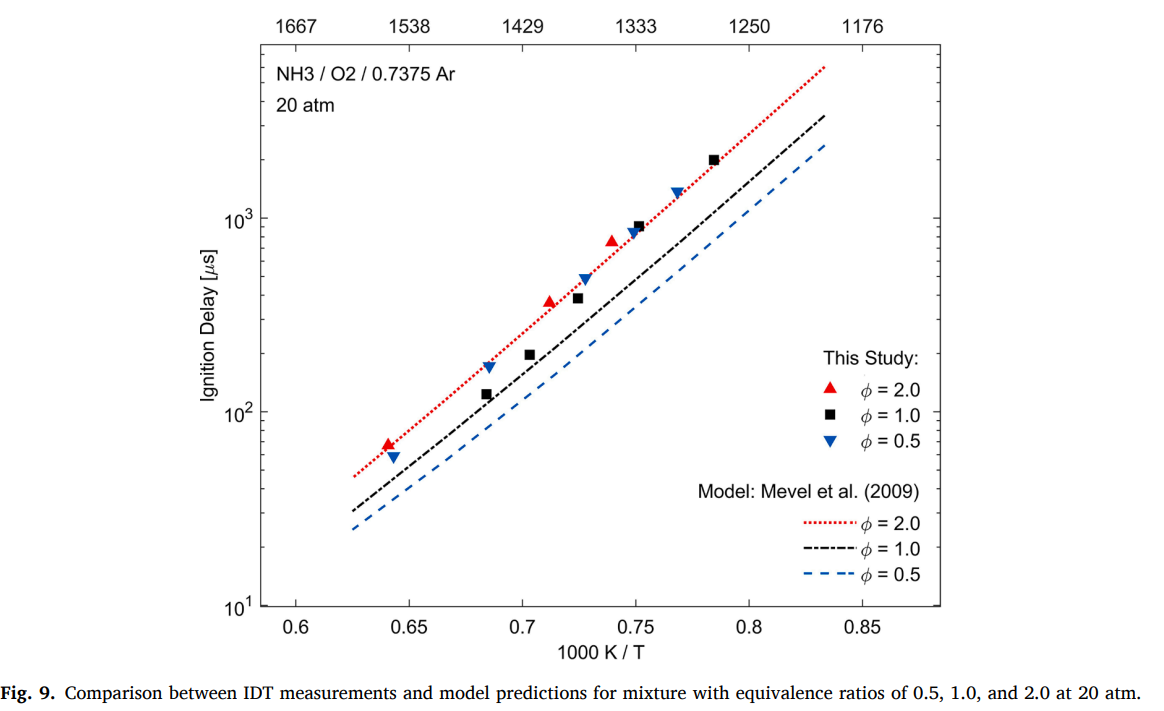

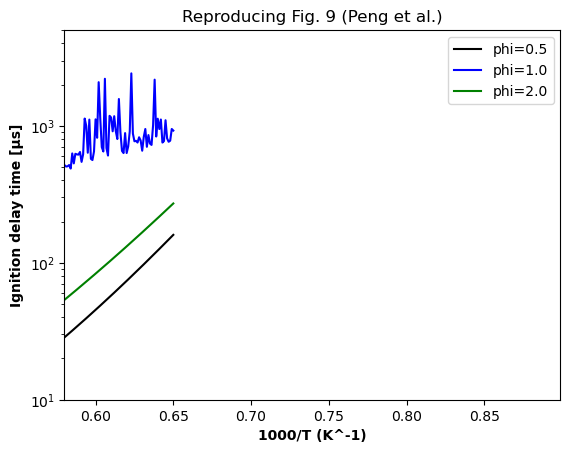

In [23]:
#REPRODUCING FIG 9
def plotIgnitionDelay_Fig9(fname,phi,pltColour,pltLabel="_hidden"): #ign delays plotted in units of μs by default
    T=np.divide(1000,np.arange(0.47, 0.65, 0.001))
    P=20*101325
    refSpecies = "O"
    estimated_ignition_delay_times = 0.7*np.ones_like(T, dtype=float)
    gas = ct.Solution(fname)
    ignition_delays = ct.SolutionArray(gas, shape=T.shape, extra={"tau": estimated_ignition_delay_times})
    ignition_delays.TP = T, P
    ignition_delays.set_equivalence_ratio(phi,'NH3','O2',diluent='Ar:1', fraction={"diluent":0.7375},basis='mole')
    tau_list=[]
    for i, state in enumerate(ignition_delays):
        gas.TPX = state.TPX
        r = ct.Reactor(contents=gas, energy='on')
        reactor_network = ct.ReactorNet([r])
        refSpecies_history = []
        time_history = []
        t = 0
        while t < estimated_ignition_delay_times[i]:
            t = reactor_network.step()
            time_history.append(t)
            refSpecies_history.append(gas[refSpecies].X[0])
        i_ign = np.array(refSpecies_history).argmax()
        tau = time_history[i_ign]
        tau_list.append(tau) 
    plt.semilogy(1000 / ignition_delays.T, np.multiply(1e6,tau_list),'-',color=pltColour, marker=None,label=pltLabel)


plt.figure()
fname='test/data/alzuetamechanism.yaml'
plotIgnitionDelay_Fig9(fname,0.5,'k',pltLabel="phi=0.5")
plotIgnitionDelay_Fig9(fname,1.0,'b',pltLabel="phi=1.0")
plotIgnitionDelay_Fig9(fname,2.0,'g',pltLabel="phi=2.0")

plt.title("Reproducing Fig. 9 (Peng et al.)")
plt.ylabel("Ignition delay time [μs]",**hfont)
plt.xlabel(r"1000/T (K^-1)", **hfont)
plt.ylim([10,5000])
plt.xlim([0.58,0.899])
plt.legend()
plt.show()

### 5) FLAME BURNING RATE PLOTS
#### 5.1) H2/O2/He mixture 
* Figure 1, 2: ["Assessment of kinetic modeling for lean H2/CH4/O2/diluent flames at high pressures" (Burke et al.)](https://drive.google.com/file/d/1SP44K4k0oS81g19Gny2TQxCgBMXFXboB/view?usp=sharing)
* Further reading: ["Evaluating Mixture Rules for Multi-Component Pressure Dependence: H+O2 (+M)=HO2 (+M)" (Burke et al.)](https://drive.google.com/file/d/1VsMwxM_VrQSqbVT4c5ARn_KthV4oLiWJ/view?usp=sharing), ["Negative pressure dependence of mass burning rates of H2/CO/O2/diluent flames at low flame temperatures" (Burke et al.)](https://drive.google.com/file/d/1vTAJ_EpAyKNhtb_uAUpahS91CbWAw3Ej/view?usp=sharing)

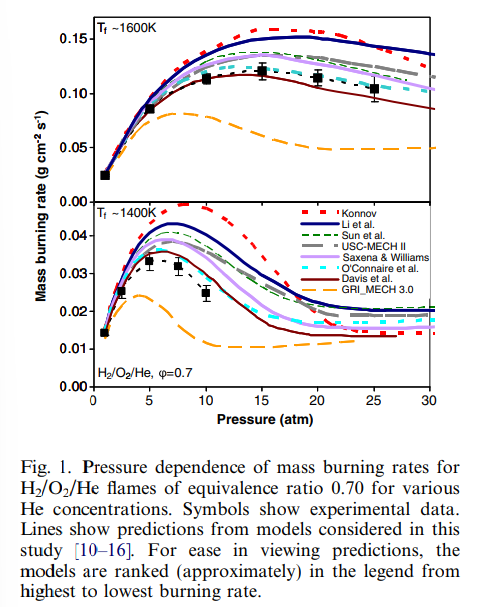


************ Solving on 8 point grid with energy equation enabled ************

..............................................................................
Attempt Newton solution of steady-state problem...    failure. 
Take 10 timesteps      1.78e-06      6.167
Attempt Newton solution of steady-state problem...    failure. 
Take 10 timesteps     2.175e-11      6.152
Attempt Newton solution of steady-state problem...    failure. 
Take 10 timesteps   
 
*******************************************************************************
CanteraError thrown by OneDim::timeStep:
Time integration failed.
*******************************************************************************
 

******** Initial solve failed; Retrying with energy equation disabled ********

..............................................................................
Attempt Newton solution of steady-state problem...    failure. 
Take 10 timesteps     0.0001281      2.435
Attempt Newton solution of steady-state prob

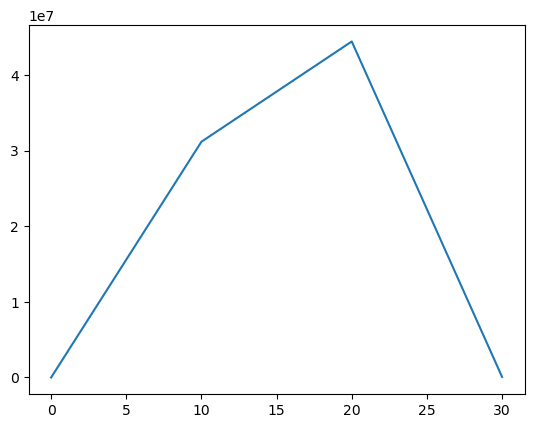

In [32]:
# REPRODUCING BURKE FIGURE 1

# I need to plot the mass burning rate, not the flame speed. How do I do this?

def plotFlameSpeed_BurkeFig1(fname,T):
    P=np.linspace(0.001,30,4)#Using a very small number of points in P array for now, because otherwise sim time would be too long
    phi=0.7
    # width=[0.08,0.03,0.015,0.008]
    width=0.03 #[m] how do we know the flame width?
    loglevel = 1 # amount of diagnostic output (0 to 8)
    fspeed=[]
    for j in range(len(P)):
        # Solution object used to compute mixture properties, set to the state of the
        # upstream fuel-air mixture
        gas = ct.Solution(fname)
        gas.TP = T, P[j]*ct.one_atm
        gas.set_equivalence_ratio(phi,'H2','O2',diluent='He:1', fraction={"diluent":0.3},basis='mole') # NOTE: DILUENT FRACTION OF 0.3 IS A PLACEHOLDER. MUST FIND REAL NUMBER.
        # Create the flame object
        f = ct.FreeFlame(gas,width=width)
        f.set_refine_criteria(ratio=3, slope=0.06, curve=0.12) # Define tolerances for the solver
        # f.show()
        f.transport_model='multicomponent'
        f.solve(loglevel,auto=True)
        fspeed.append(f.velocity[0]) #[m/s] multicomponent flame speed
        print(f.velocity[0])
    print(fspeed)
    plt.plot(P,fspeed)
    
plt.figure()
plotFlameSpeed_BurkeFig1('test/data/alzuetamechanism.yaml',T=1400)
plotFlameSpeed_BurkeFig1('test/data/alzuetamechanism.yaml',T=1600)
plt.show()

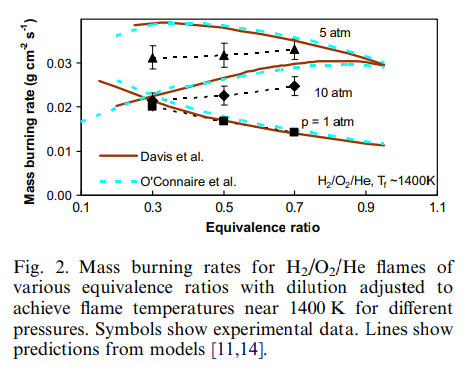

In [ ]:
# REPRODUCING BURKE FIGURE 2

# I need to plot the mass burning rate, not the flame speed. How do I do this?

def plotFlameSpeed_BurkeFig2(fname,P):
    T=1400
    phi=np.linspace(0.15,1.0,4)#Using a very small number of points in phi array for now, because otherwise sim time would be too long
    # width=[0.08,0.03,0.015,0.008]
    width=0.03 #[m] how do we know the flame width?
    loglevel = 1 # amount of diagnostic output (0 to 8)
    fspeed=[]
    for j in range(len(phi)):
        # Solution object used to compute mixture properties, set to the state of the
        # upstream fuel-air mixture
        gas = ct.Solution(fname)
        gas.TP = T, P*ct.one_atm
        gas.set_equivalence_ratio(phi[j],'H2','O2',diluent='He:1', fraction={"diluent":0.3},basis='mole') # NOTE: DILUENT FRACTION OF 0.3 IS A PLACEHOLDER. MUST FIND REAL NUMBER.
        # Create the flame object
        f = ct.FreeFlame(gas,width=width)
        f.set_refine_criteria(ratio=3, slope=0.06, curve=0.12) # Define tolerances for the solver
        # f.show()
        f.transport_model='multicomponent'
        f.solve(loglevel,auto=True)
        fspeed.append(f.velocity[0]) #[m/s] multicomponent flame speed
        print(f.velocity[0])
    print(fspeed)
    plt.plot(phi,fspeed)

#REPRODUCING FIGURE 2
plt.figure()
plotFlameSpeed_BurkeFig2('test/data/alzuetamechanism.yaml',P=1)
plotFlameSpeed_BurkeFig2('test/data/alzuetamechanism.yaml',P=5)
plotFlameSpeed_BurkeFig2('test/data/alzuetamechanism.yaml',P=10)
plt.show()

#### 5.2) H2/H2O mixture 
* Figure 2a: ["The effects of water dilution on hydrogen, syngas, and ethylene flames at elevated pressure" (Santner et al.)](https://drive.google.com/file/d/1eijNHH4XoFlrORzyl55VKOU7b3VqTWie/view?usp=sharing)

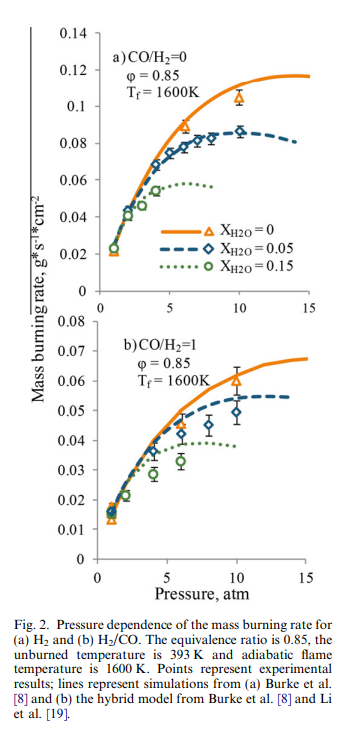

In [1]:
# REPRODUCING SANTNER FIGURE 2A

def plotFlameSpeed_SantnerFig2A(fname,X_H2O):
    P=np.linspace(0.001,30,4)#Using a very small number of points in P array for now, because otherwise sim time would be too long
    phi=0.85
    T=1600
    # width=[0.08,0.03,0.015,0.008]
    width=0.03 #[m] how do we know the flame width?
    loglevel = 1 # amount of diagnostic output (0 to 8)
    fspeed=[]
    for j in range(len(P)):
        # Solution object used to compute mixture properties, set to the state of the
        # upstream fuel-air mixture
        gas = ct.Solution(fname)
        gas.TP = T, P[j]*ct.one_atm
        gas.set_equivalence_ratio(phi,'H2','O2',diluent='H2O:1', fraction={"diluent":X_H2O},basis='mole') # NOTE: NEED TO CHECK IF THE OXIDIZER IS ACTUALLY O2
        # Create the flame object
        f = ct.FreeFlame(gas,width=width)
        f.set_refine_criteria(ratio=3, slope=0.06, curve=0.12) # Define tolerances for the solver
        # f.show()
        f.transport_model='multicomponent'
        f.solve(loglevel,auto=True)
        fspeed.append(f.velocity[0]) #[m/s] multicomponent flame speed
        print(f.velocity[0])
    print(fspeed)
    plt.plot(P,fspeed)
    
plt.figure()
plotFlameSpeed_SantnerFig2A('test/data/alzuetamechanism.yaml',X_H2O=0.00)
plotFlameSpeed_SantnerFig2A('test/data/alzuetamechanism.yaml',X_H2O=0.05)
plotFlameSpeed_SantnerFig2A('test/data/alzuetamechanism.yaml',X_H2O=0.15)
plt.show()


KeyboardInterrupt



#### 5.3) NH3/air mixture 
* Figure 1: ["Effect of Chemistry and Transport Properties on Near-Limit Flames at Microgravity" (Paul D Ronney)](https://drive.google.com/file/d/187j_Co3Qqg4c6BtydoD7PCRcT2uURtrj/view?usp=sharing)

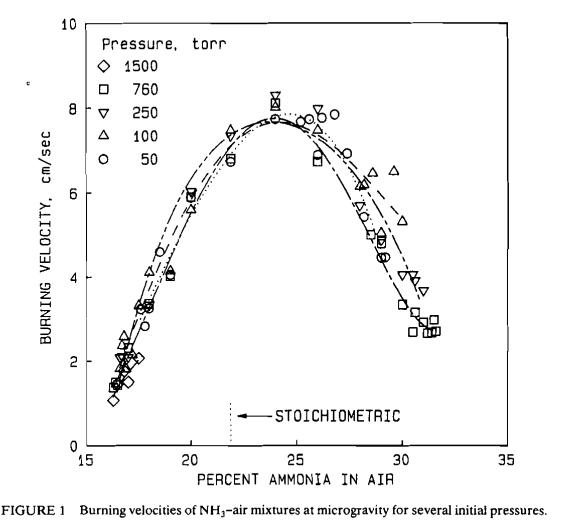

In [ ]:
# REPRODUCING RONNEY FIGURE 1

def plotFlameSpeed_RonneyFig1(fname,P):
    X_NH3=np.linspace(0.16,0.32,4)#Using a very small number of points in X_NH3 array for now, because otherwise sim time would be too long
    X_air = 1-X_NH3
    X_O2 = 1/(1+3.76)*X_air
    X_N2 = 1-X_NH3-X_O2
    T=1600 #THIS IS A PLACEHOLDER. STILL NEED TO FIND REAL VALUE OF TEMPERATURE
    width=0.03
    loglevel = 1
    fspeed=[]
    for j in range(len(X_NH3)):
        gas = ct.Solution(fname)
        gas.TP = T, P[j]*ct.one_atm
        gas.X = {'NH3':X_NH3[j],'O2':X_O2,'N2':X_N2}
        f = ct.FreeFlame(gas,width=width)
        f.set_refine_criteria(ratio=3, slope=0.06, curve=0.12)
        f.transport_model='multicomponent'
        f.solve(loglevel,auto=True)
        fspeed.append(f.velocity[0])
        print(f.velocity[0])
    print(fspeed)
    plt.plot(X_NH3,fspeed)
    
plt.figure()
plotFlameSpeed_RonneyFig1('test/data/alzuetamechanism.yaml',P=760/50)
plotFlameSpeed_RonneyFig1('test/data/alzuetamechanism.yaml',P=760/100)
plotFlameSpeed_RonneyFig1('test/data/alzuetamechanism.yaml',P=760/250)
plotFlameSpeed_RonneyFig1('test/data/alzuetamechanism.yaml',P=760/760)
plotFlameSpeed_RonneyFig1('test/data/alzuetamechanism.yaml',P=760/1500)
plt.show()